# **Исследование телеграм-канала города Иннополис**

## План работы:
1. Откроем файлы с данными и изучим общую информацию
2. Подготовим данные к работе (проверим пропуски, типы данных, объединим датафреймы в один)
3. Проведем исследовательский анализ данных (частотный анализ слов постов и комментариев, анализ времени публикаций, семантический анализ комментариев к постам, анализ реакций на сообщения, формирование метрик оценки популярности поста, анализ эмодзи к постам)
4. Сформулируем выводы и рекомендации

Иннополис – первый и пока единственный российский город для ИТ-специалистов, построенный с нуля в современной истории России. Сейчас в нём живут и работают более 7 500 человек, и 68% жителей переехали из других регионов РФ, а 6% — иностранные граждане. На сегодняшний день в городе есть вся необходимая социальная инфраструктура: детские сады, школа, ИТ-лицей, больница, городские пространства. Здесь открыт первый в России ИТ-вуз — Университет Иннополис.

Заказчик данного исследования - отдела маркетинга и PR города Иннополис - хочет увеличить лояльной аудитории бренда путем увеличения количества подписчиков телеграм-канала @innopolistg. Повышение лояльности необходимо для того, чтобы читатели канала в будущем стали жителями Иннополиса.

В ходе исследования необходимо провести анализ нынешнего состояния телеграм-канала города и выявить наиболее эффективные и точные метрики для
еженедельного/ежемесячного анализа работы.

Для работы мы получили 3 датасета:


*   датасет innopolistg.csv содержит информацию о дате публикации, текстовом содержании поста, его id, количестве просмотров, количество эмодзи, наличии фото или видео, прикрепленного к посту, а также количестве комментариев
*   дополнительный датасет comments_innopolistg_061223 содержит текст комментариев постам
*   дополнительный датасет  innopolistg_emoji содержит статистику по каждому эмодзи, примененному в публикациях



In [1]:
pip install pymorphy2

In [2]:
#импортируем необходимые дял работы библиотеки
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import gspread
import string
import re
import nltk
import pymorphy2
from google.colab import auth
from google.auth import default
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
auth.authenticate_user()
creds, _=default()
gc = gspread.authorize(creds)

### 1. Откроем файл с данными и изучим общую информацию

In [4]:
# зададим функцию data_check для первичной оценки данных
def data_check(df):
    df.info()
    print('Проверка наличия дубликатов:', df.duplicated().sum())
    print('Проверка наличия пропусков:', df.isna().sum().sum())
    none_counter = 0
    for attribute in df.columns:
        none_counter += df[df[attribute].isin(['NaN', 'nan', 'None', 'none', 'NA', 'Na', 'na', '', ' '])].shape[0]
    print('Проверка наличия скрытых пропусков:', none_counter)
    display(df.head())

In [5]:
# откроем первый файл и загрузим в переменную df, сразу передав его функции data_check
Da = gc.open_by_key('1VBxOcWfGsTYwsp1KTRVYLkO3K1yjg8oQbboQoeIwaio')
Da_df = Da.worksheet('innopolistg')
rows = Da_df.get_all_values()
df = pd.DataFrame.from_records(rows[1:], columns=rows[0])
data_check(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0                    536 non-null    object
 1   channel          536 non-null    object
 2   id               536 non-null    object
 3   date             536 non-null    object
 4   text             536 non-null    object
 5   views            536 non-null    object
 6   reactions_count  536 non-null    object
 7   comments         536 non-null    object
 8   type_attachment  536 non-null    object
dtypes: object(9)
memory usage: 37.8+ KB
Проверка наличия дубликатов: 0
Проверка наличия пропусков: 0
Проверка наличия скрытых пропусков: 48


channel    id                       date  \
0   0  https://t.me/innopolistg  1414  2023-12-04 09:31:49+00:00   
1   7  https://t.me/innopolistg  1407  2023-12-01 14:40:01+00:00   
2   8  https://t.me/innopolistg  1406  2023-12-01 04:16:17+00:00   
3   9  https://t.me/innopolistg  1404  2023-11-30 14:05:01+00:00   
4  10  https://t.me/innopolistg  1403  2023-11-29 16:05:06+00:00   

                                                text   views reactions_count  \
0  1. Университет Иннополис [открыл штаб-квартиру...  1445.0              31   
1  Провели дискуссию о будущем туризма в Иннополи...  2234.0              51   
2  Настала пора открывать подарки\n\nПоговаривают...  2823.0             109   
3  **Новогодний адвент-календарь** **Иннополиса**...  3284.0             120   
4  Начинаем вечер-дискуссию о туризме в Иннополис...  4350.0              31   

  comments    type_attachment  
0        0  MessageMediaPhoto  
1        2  MessageMediaPhoto  
2        2  MessageMediaPhoto  
3       10  MessageMediaPhoto  
4        1  MessageMediaPhoto

Исходя из описания данных, в них должна содержаться информация о постах только из одного канала, поэтому поле channel не несет полезной информации, и его можно удалить, однако предварительно убедимся, что данные только по одному каналу. Также удалим ненужное поле с исходными id строк. Также в данных имеется значительное количество потенциальных пропусков, обнаруженных функцией data_check. Для их проверки зададим функцию examining_missing_values.

In [6]:
df['channel'].nunique()

1

In [7]:
df = df.drop(['', 'channel'], axis=1)

In [8]:
# функция принимает на вход название датафрейма, проходит циклом по его полям, подсчитывая количество попадающих под заданнные шаблоны значений в строках и формирует новую таблицу
# nan_columns_table, в которой полями являются поля исходного датафрейма, а строками счетчики по соответствующим шаблонам
def examining_missing_values(data):
    len_list = []
    nan_count_list = []
    empty_string_count_list = []
    space_count_list = []
    for column in data.columns.to_list():
        len_list.append(data[column].count())
        nan_count_list.append(data[data[column].isin(['NaN', 'nan', 'None', 'none', 'NA', 'Na', 'na']) == True].shape[0])
        empty_string_count_list.append(data[data[column].isin(['']) == True].shape[0])
        space_count_list.append(data[data[column].isin([' ']) == True].shape[0])

    nan_columns_table = pd.DataFrame((len_list, nan_count_list, empty_string_count_list, space_count_list), index=[
        'value_count', 'NaN_str_count', 'empty_string_count', 'space_count'], columns=data.columns)
    display(nan_columns_table)

In [9]:
examining_missing_values(df)

id  date  text  views  reactions_count  comments  \
value_count         536   536   536    536              536       536   
NaN_str_count         0     0     0      0                0         0   
empty_string_count    0     0     0      0                0         0   
space_count           0     0     0      0                0         0   

                    type_attachment  
value_count                     536  
NaN_str_count                     0  
empty_string_count               48  
space_count                       0

Все 48 потенциальных пропусков находятся в поле type_attachment и представляют собой пустую строку (''). Более подробно изучим это поле в исследовательском анализе данных.

In [10]:
# откроем второй файл и загрузим в переменную df_comm, первично проверим данные
Da_comment = gc.open_by_key('1Z6Kn2BkLNkg6sQuJu7co7d0lrSTC14VzligkjD_P4t4')
Da_df_comment = Da_comment.worksheet('comments_innopolistg_061223')
rows = Da_df_comment.get_all_values()
df_comment = pd.DataFrame.from_records(rows[1:], columns=rows[0])
data_check(df_comment)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0                 2511 non-null   object
 1   post_id       2511 non-null   object
 2   date_comment  2511 non-null   object
 3   text_comment  2511 non-null   object
dtypes: object(4)
memory usage: 78.6+ KB
Проверка наличия дубликатов: 0
Проверка наличия пропусков: 0
Проверка наличия скрытых пропусков: 498


post_id               date_comment  \
0  0    1421  2023-12-06 12:42:17+00:00   
1  1    1421  2023-12-06 12:42:40+00:00   
2  2    1421  2023-12-06 12:46:43+00:00   
3  3    1421  2023-12-06 13:55:10+00:00   
4  4    1420  2023-12-05 06:04:14+00:00   

                                        text_comment  
0                                                  💔  
1                                                     
2  Предлагаю также в других номинациях голосовать...  
3                                                 ❤️  
4  Очень интересное сотрудничество! Уверен, что в...

Аналогично первому датафрейму удалим первое поле с исходными id строк и применим функцию examining_missing_values для локализации большого количества потенциальных пропусков.

In [11]:
df_comment = df_comment.drop('', axis=1)
examining_missing_values(df_comment)

post_id  date_comment  text_comment
value_count            2511          2511          2511
NaN_str_count             0             0             0
empty_string_count        0             0           498
space_count               0             0             0

Все пропуски локализованы в поле text_comment, возможно это удаленные комментарии. Проверим эту гипотезу в исследовательском анализе.

In [12]:
# откроем последний файл, загрузим в переменную df_emoji и проверим функцией data_check
Da_emoji = gc.open_by_key('18lYiZgOCUaaSEt8BpF0d5jX4NUM-GKDqCTCXC5-6MFs')
Da_df_emoji = Da_emoji.worksheet('innopolistg_emoji')
rows = Da_df_emoji.get_all_values()
df_emoji = pd.DataFrame.from_records(rows[1:], columns=rows[0])
data_check(df_emoji)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0                    539 non-null    object
 1   index            539 non-null    object
 2   channel          539 non-null    object
 3   id               539 non-null    object
 4   date             539 non-null    object
 5   text             539 non-null    object
 6   views            539 non-null    object
 7   reactions_count  539 non-null    object
 8   comments         539 non-null    object
 9   type_attachment  539 non-null    object
 10  reactions        539 non-null    object
dtypes: object(11)
memory usage: 46.4+ KB
Проверка наличия дубликатов: 0
Проверка наличия пропусков: 0
Проверка наличия скрытых пропусков: 53


index                   channel    id                       date  \
0  0     5  https://t.me/innopolistg  1421  2023-12-06 12:41:17+00:00   
1  1     6  https://t.me/innopolistg  1420  2023-12-05 06:01:58+00:00   
2  2    11  https://t.me/innopolistg  1415  2023-12-04 15:15:49+00:00   
3  3    12  https://t.me/innopolistg  1414  2023-12-04 09:31:49+00:00   
4  4    19  https://t.me/innopolistg  1407  2023-12-01 14:40:01+00:00   

                                                text   views reactions_count  \
0  2023 год подходит к концу. И мы вспоминаем сам...  2294.0              45   
1  В поисках новых подарков Дед Мороз заглянул в ...  2116.0              36   
2  В первую неделю зимы слушаем классическую музы...  2175.0              22   
3  1. Университет Иннополис [открыл штаб-квартиру...  2391.0              38   
4  Провели дискуссию о будущем туризма в Иннополи...  2819.0              52   

  comments    type_attachment  \
0        4  MessageMediaPhoto   
1        6  MessageMediaPhoto   
2        3  MessageMediaPhoto   
3        0  MessageMediaPhoto   
4        2  MessageMediaPhoto   

                                           reactions  
0  {'_': 'MessageReactions', 'results': [{'_': 'R...  
1  {'_': 'MessageReactions', 'results': [{'_': 'R...  
2  {'_': 'MessageReactions', 'results': [{'_': 'R...  
3  {'_': 'MessageReactions', 'results': [{'_': 'R...  
4  {'_': 'MessageReactions', 'results': [{'_': 'R...

Удостоверяемся, что в данных посты только из одного канала, удаляем ненужные для дальнейшей работы три первые колонки и ищем скрытие пропуски.

In [13]:
df_emoji['channel'].nunique()

1

In [14]:
df_emoji = df_emoji.drop(['', 'index', 'channel'], axis=1)
examining_missing_values(df_emoji)

id  date  text  views  reactions_count  comments  \
value_count         539   539   539    539              539       539   
NaN_str_count         0     0     0      0                0         0   
empty_string_count    0     0     0      0                0         0   
space_count           0     0     0      0                0         0   

                    type_attachment  reactions  
value_count                     539        539  
NaN_str_count                     0          0  
empty_string_count               48          5  
space_count                       0          0

Для анализа данных мы получили 3 датасета:
* первый датасет содержит 536 записей о постах телеграм-канала с информацией о дате публикации, текстовом содержании поста, его id, количестве просмотров, количестве эмодзи, наличии фото или видео, прикрепленного к посту, а также количестве комментариев
* второй датасет содержит 2 511 записей о id поста, дате комментария к нему и тексте комментария
* третий датасет содержит 539 записей и практически дублирует информацию, содержащуюся в первом датасете, с добавлением статистики по каждому эмодзи, примененному в публикациях
Для дальнейшей работы изменим тип данных в столбцах, содержащих информацию о дате и времени публикации, комментария, количестве прoсмотров, эмодзи и комментариев.

### 2. Подготовим данные к работе

In [15]:
# изменим типы данных в столбцах с информацией о дате и времени публикации, комментария, количестве прoсмотров, эмодзи и комментариев
df['date'] = pd.to_datetime(df['date']).dt.tz_convert(None)
df_comment['date_comment'] = pd.to_datetime(df_comment['date_comment']).dt.tz_convert(None)
df_emoji['date'] = pd.to_datetime(df_emoji['date']).dt.tz_convert(None)
df['views'] = pd.to_numeric(df['views']).astype('int')
df[['id', 'reactions_count', 'comments']] = df[['id', 'reactions_count', 'comments']].astype('int')
df_comment['post_id'] = df_comment['post_id'].astype('int')
df_emoji['views'] = pd.to_numeric(df_emoji['views']).astype('int')
df_emoji[['id', 'reactions_count', 'comments']] = df_emoji[['id', 'reactions_count', 'comments']].astype('int')

Данные в датафреймах df и df_emoji практически полностью идентичны, за исключением поля со словарем емодзи во второй таблице и в разнице количества строк. Вероятно, информация в таблицах охватывает немного разный временной диапазон, нужно это проверить.

In [16]:
print('Диапазон дат df:', df['date'].agg({'min', 'max'}), sep = '\n')
print('Диапазон дат df_emoji:')
df_emoji['date'].agg({'min', 'max'})

Диапазон дат df:
min   2022-03-01 13:11:03
max   2023-12-04 09:31:49
Name: date, dtype: datetime64[ns]
Диапазон дат df_emoji:


min   2022-03-01 13:11:03
max   2023-12-06 12:41:17
Name: date, dtype: datetime64[ns]

Стартовый диапазон дат одинаков, таблица df_emoji содержит три дополнительных поста и информацию о реакциях, поэтому в дальнейшем анализе df не будет использоваться. Таким образом для дальнейшего анализа мы будем использовать 2 таблицы:
* df_emoji, содержащий 539 записей о постах телеграм-канала с информацией о дате публикации, текстовом содержании поста, его id, количестве просмотров, количестве реакций с добавлением статистики по каждому эмодзи, наличии фото или видео, прикрепленного к посту, а также количестве комментариев
* df_comment содержит 2 511 записей о комментариях и включает id поста, дату комментария и текст комментария.

Проанализируем распределение публикаций по типу вложения (поле type_attachment).

In [17]:
round(df_emoji['type_attachment'].value_counts(normalize=True) * 100, 1)

MessageMediaPhoto       80.3
MessageMediaDocument     9.3
                         8.9
MessageMediaWebPage      1.5
Name: type_attachment, dtype: float64

Подавляющее количество постов, более 80%, сопровождается прикрепленными изображениями, при этом почти у 9% постов отсутствует тип вложения, что значит, что пост содержит только текст. Однако, беглый просмотр таких постов показывает, что в них часто встречаются ссылки, да и по логике посты содержащие исключительно текст должны быть самыми редкими. Поэтому зададим функцию `check_links` которая будет проверять текст постов пустыми стоками в поле type_attachment и если там будут элементы URL-ссылок, присваивать значение MessageMediaWebPage, если же таких элементов нет, то значение TextWithoutAttachment.

In [18]:
# задаем функцию для обновления значения в столбце type_attachment
def check_links(row):
    if row['type_attachment'] == '' and re.search(r'(www|http)', row['text']):
        return 'MessageMediaWebPage'
    elif row['type_attachment'] == '':
        return 'TextWithoutAttachment'
    else:
        return row['type_attachment']

# перезаписываем значения в столбце type_attachment, если текст содержит 'www' или 'http'
df_emoji['type_attachment'] = df_emoji.apply(check_links, axis=1)

Проверим как поменялось распределение постов по типам.

In [19]:
round(df_emoji['type_attachment'].value_counts(normalize=True) * 100, 1)

MessageMediaPhoto        80.3
MessageMediaDocument      9.3
MessageMediaWebPage       6.7
TextWithoutAttachment     3.7
Name: type_attachment, dtype: float64

Как и ожидалось, посты без каких-либо вложений стали наименее частотными, а посты содержащие ссылки поднялись на третье место, увеличив свою долю более чем в 4 раза.

Для дальнейшего анализа создадим следующие новые поля:

* character_count - количество символов в тексте поста;
* punctuation - количество запятых, двоеточий и символов переноса строки (\n) - необходим для расчета коэффициента сложности текста;
* difficulty_factor - коэффициент сложности теста, соотношение количества выделенных знаков пунктуации к количеству символов, чем он выше, тем сложнее текст.

In [20]:
df_emoji['character_count'] = df_emoji['text'].apply(lambda x: len(x))
df_emoji['punctuation'] = df_emoji['text'].apply(lambda x: x.count(',') + x.count(':') + x.count('\n') + x.count('-') + x.count('(') + x.count(')'))
df_emoji['difficulty_factor'] = round(df_emoji['punctuation'] / df_emoji['character_count'], 3)

Для того, чтбы оценить эффективность коммуникации с подписчиками канала необходимо соотнести содержание постов с конкретными темами. Для этого прежде всего необходимо подготовить тексты постов для категоризации, а именно разбить их на слова, очистить от знаков пунктуации, предлогов, союзов и т.п., после чего лемматизировать оставшееся. Для этого зададим функцию `lemmatization_of_text`.

In [21]:
def lemmatization_of_text(row):
    text_no_urls = re.sub(r'http\S+|www\S+', '', row['text'])
    del_char = re.sub(f"[{re.escape(spec_chars)}]", ' ', text_no_urls)
    cleaned_text = del_char.lower().split(sep=' ')
    cleaned_text = [word for word in cleaned_text if len(word) > 3]
    lemmas = []
    for word in cleaned_text:
        lemmas.append(morph.parse(word)[0].normal_form)
    return lemmas

In [22]:
# создаем экземпляр класса MorphAnalyzer
morph = pymorphy2.MorphAnalyzer()
# записываем в переменную spec_chars знакb пунктуации, символы переноса строки, табуляции и другие символы, которые встречаются в исходном тексте
spec_chars = string.punctuation + '\n\xa0«»\t—…'
# применяем функцию lemmatization_of_text к датафрейму для создания колонки со списком лемматизированных слов
df_emoji['lemmas_text'] = df_emoji.apply(lemmatization_of_text, axis=1)

Далее зададим словарь  topic_dictionary, в котором будут заданы следующие темы и соответсвующие им ключевые слова:
*   анонсы
*   розыгрыши
*   вакансии
*   новости
*   университет
*   for_fun (развлекательный контент)
*   опросы
*   локации (посты с фотографиями города и природы)
*   досуг

In [23]:
topic_dictionary = {
    'анонсы': ['анонсировано', 'мероприятие', 'спектакль', 'квиз', 'квиза', 'конференц', 'лекция', 'фестиваль', 'митапа', 'meetup', 'праздник', 'спикер', 'разобраться',
               'приходить', 'забег', 'питчинга'],
    'розыгрыши': ['адвент', 'подарок'],
    'вакансии': ['вакансия', 'офер', 'онбординг'],
    'новости': ['новость', 'открыть', 'исследование', 'узнать', 'указ', 'постановление', 'поддержка', 'стипендия', 'рассказать', 'поделиться', 'проект', 'ровер', 'импортозамещение',
                'сделка', 'google', 'победить', 'герой', 'красат', 'реддитор', 'openai', 'яндекс', 'intel', 'ieee', 'inn8', 'zion', 'вспоминать', 'мерч', 'gucci', 'дорисовать',
                'открывать', 'microsoft', 'патент', 'илона', 'поздравлять', 'достижение', 'создать', 'вжухнуть', 'провести', 'amazon', 'бот', 'минцифра', 'apple', 'квартал','выглядеть'],
    'университет': ['университет', 'студент'],
    'for_fun': ['словарь', 'плейлист', 'айтишник', 'айти', 'айтишный', 'совет', 'соцсеть', 'словарик', 'шутка', 'сохраниться', 'хайп', 'диджей', 'врываться', 'пост', 'complete', 'контент',
                'полшестого', 'история', 'бывать', 'начинающий', 'скайнуть', 'математика', 'cпасибо', 'признаваться', 'собрать', 'таска', 'игра', 'статья', 'свой', 'денис', 'рубик',
                'спасибо', 'хорошо', 'остер', 'искусство'],
    'опросы': ['опрос', 'голосовать', 'голосование', 'сыграть'],
    'локации': ['фотография', 'фотографировать', 'красивый', 'красиво', 'обои', 'иннополис', 'заставка', 'закат', 'frozen', 'затмение', 'фотка', 'cyberpunk'],
    'досуг': ['туризм', 'секция']
}

Зададим функцию `post_topic_selection`, которая построчно присваивает каждому посту группу по совпадению слов из значений словаря и сокращенного набора слов из поста, записанных в лемматизированной форме.


In [24]:
def post_topic_selection(lemmas_text):
    for key in topic_dictionary.keys():
        for topic in topic_dictionary[key]:
            if topic in lemmas_text:
                return key
    return 'категория не присвоена'

Применим функцию и убедимся, что не категоризированных постов не осталось.

In [25]:
df_emoji['topic'] = df_emoji['lemmas_text'].apply(post_topic_selection)
df_emoji.query('topic == "категория не присвоена"')[['date', 'text', 'lemmas_text']]

date text lemmas_text
397 2022-08-31 21:01:57    🍂          []
471 2022-06-04 14:24:42    🤔          []

Имеем два поста, которые не содержат текста вообще, только эмодзи. Из имеющихся категорий для таких постов наилучшим образом подходит for_fun, туда их и перенесем.

In [26]:
df_emoji['topic'] = df_emoji['topic'].replace('категория не присвоена', 'for_fun')

### 3. Исследовательский анализ данных

Теперь когда данные с постами проверены и обработаны можно приступить к исследовательскому анализу. Для начала проверим структуру полученной разбивки постов по темам.

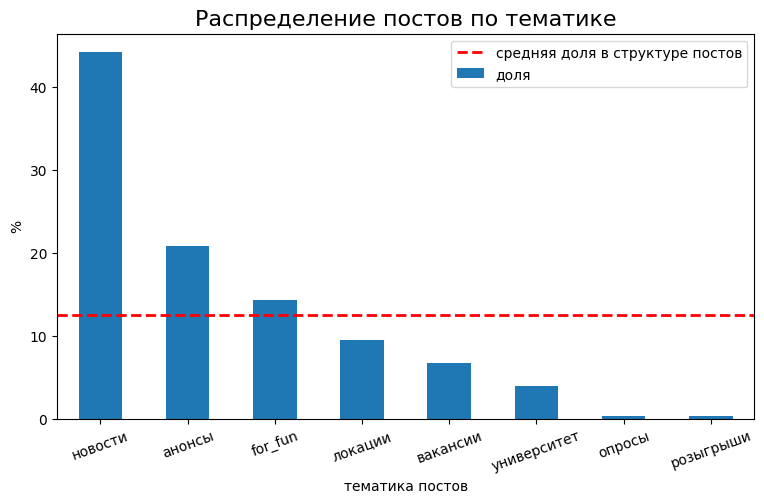

In [27]:
(df_emoji.groupby('topic')['id'].nunique() / df_emoji.shape[0] * 100).sort_values(ascending=False).plot(
    kind='bar', xlabel='тематика постов', ylabel='%', label='доля', figsize=(9, 5))
plt.xticks(rotation = 20)
plt.axhline(y=(df_emoji.groupby('topic')['id'].nunique() / df_emoji.shape[0] * 100).mean(), color='r', label='средняя доля в структуре постов', linestyle='--', linewidth=2)
plt.legend()
plt.title('Распределение постов по тематике', fontsize = 16)
plt.show()

Из 9 тем только 3 пересекают порог средней доли постов по выборке. Рубрика новостей явно доминирует, занимая почти 50% всего контента в канале, следом идут анонсы различных мероприятий и развлекательный контент (for_fun). Исчезающе мала доля постов с опросами и розыгрышами. Для более детального анализа отдельных атрибутов зададим функцию attribute_research, выдающую статистическое описание с добавленным 99% перцентилем и комбинированный график, состоящий из гистограммы с оценкой плотности ядра и диаграммы размаха, размещенных на единой оси X.

In [28]:
# функция принимает на входе имя датафрейма, название колонки с исследуемым показателем, основной заголовок графика и подпись для оси X
def attribute_research(data, attribute, title, xlabel):
    print(data[attribute].describe(percentiles=[0.05, 0.25, 0.75, 0.95, 0.99]))
    fig_num, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.1, .9)}, figsize=(10, 7))
    plt.title(title)
    plt.xlabel(xlabel)
    sns.boxplot(x=data[attribute], ax=ax_box)
    sns.histplot(x=data[attribute], ax=ax_hist, kde=True)
    ax_box.set_xlabel('')
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':')

Посмотрим как распределяется посты по количеству просмотров.

count      539.000000
mean      3952.000000
std       1658.236352
min        702.000000
5%        2115.400000
25%       2879.500000
50%       3819.000000
75%       4593.000000
95%       6138.100000
99%      11460.040000
max      18380.000000
Name: views, dtype: float64


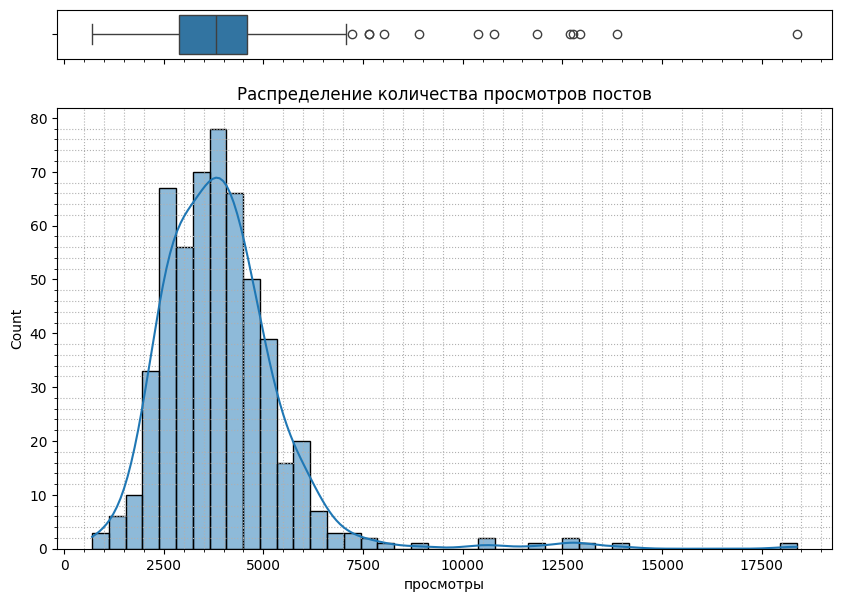

In [29]:
attribute_research(df_emoji, 'views', 'Распределение количества просмотров постов', 'просмотры')

Распеределение имеет форму нормального, пик гистограммы совпадает с медианой, а наиболее частотные значения практически укладываются в межквартильный размах. Левый ус диаграммы размаха упирается в минимальное значение, таким образом оно попадает в границу нормальных значений - в выборке нет постов с аномально низкими просмотрами. Посты с количеством просмотров более 7 тысяч попадают в зону выбросов, при этом 99% перцентиль находится в районе 11,5 тысяч просмотров.
Из общей статистики канала известно, что за временной диапазон представленный в данных количество подписчиков увеличилось в несколько раз, что очевидным образом влияет на динамику просмотров. Для её оценки построим линейный график, отображающий помесячное количество просмотров постов на канале.

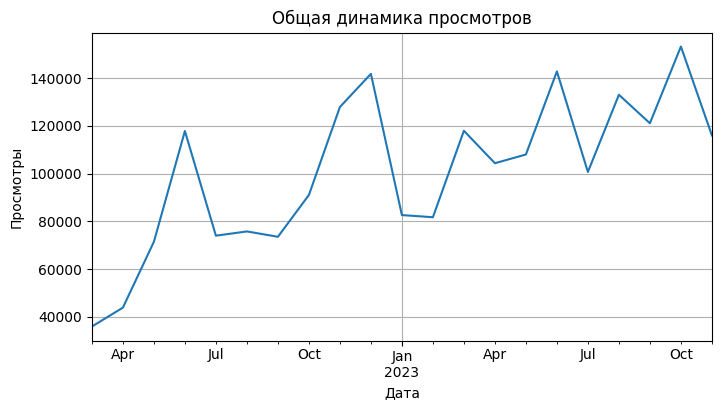

In [30]:
df_emoji[pd.to_datetime(df_emoji['date']) < '12-2023'].groupby(df_emoji['date'].dt.to_period('M')).agg({'views': 'sum'}).plot(
    xlabel='Дата', ylabel='Просмотры', title='Общая динамика просмотров', grid=True, legend=False, figsize=(8, 4))
plt.show()

Динамика числа просмотров показывает взрывной рост на старте наблюдений, имеет общую положительную теденцию, но не постоянна - имеет т.н. форму пилы.

Перейдем к анализу следующего параметра.

count    539.000000
mean      47.385900
std       39.937445
min        0.000000
5%        11.000000
25%       20.000000
50%       31.000000
75%       63.000000
95%      133.000000
99%      173.680000
max      256.000000
Name: reactions_count, dtype: float64


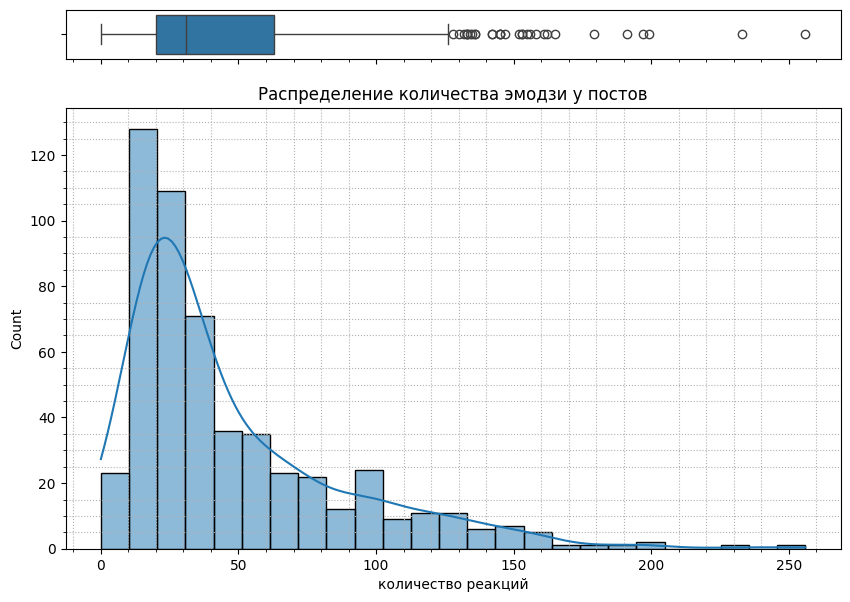

In [31]:
attribute_research(df_emoji, 'reactions_count', 'Распределение количества эмодзи у постов', 'количество реакций')

Пик гистограммы приходится в область первого квартиля - обычно посты собирают не так много эмодзи. Присутствуют нулевые значения, левый ус диаграммы размаха упирается в минимальное значение, аналогично распределению просмотров нет постов с аномально низким количеством реакций, зато зона аномально высоких значений занимает практически половину оси X распределения. Рекорд - 256 реакций на пост, при этом третий квартиль остановился на 63 реакциях. Оценим динамику за период.

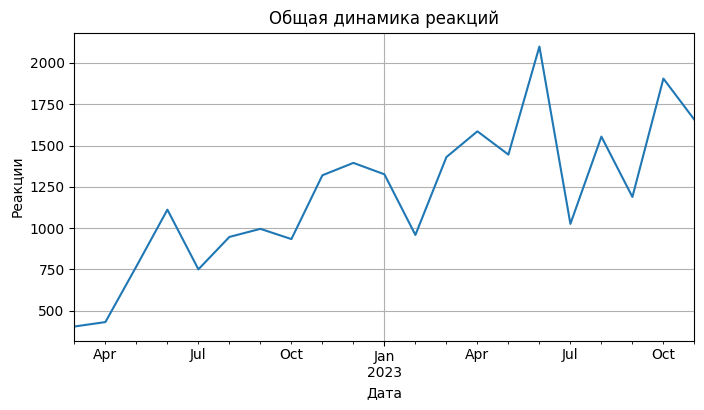

In [32]:
df_emoji[pd.to_datetime(df_emoji['date']) < '12-2023'].groupby(df_emoji['date'].dt.to_period('M')).agg({'reactions_count': 'sum'}).plot(
    xlabel='Дата', ylabel='Реакции', title='Общая динамика реакций', grid=True, legend=False, figsize=(8, 4))
plt.show()

Рост количества реакций более равномерный, чем у просмотров. На лицо положительный тренд, объясняющийся ростом аудитории канала.

count    539.000000
mean       4.658627
std       10.731185
min        0.000000
5%         0.000000
25%        0.000000
50%        2.000000
75%        5.500000
95%       18.100000
99%       35.000000
max      142.000000
Name: comments, dtype: float64


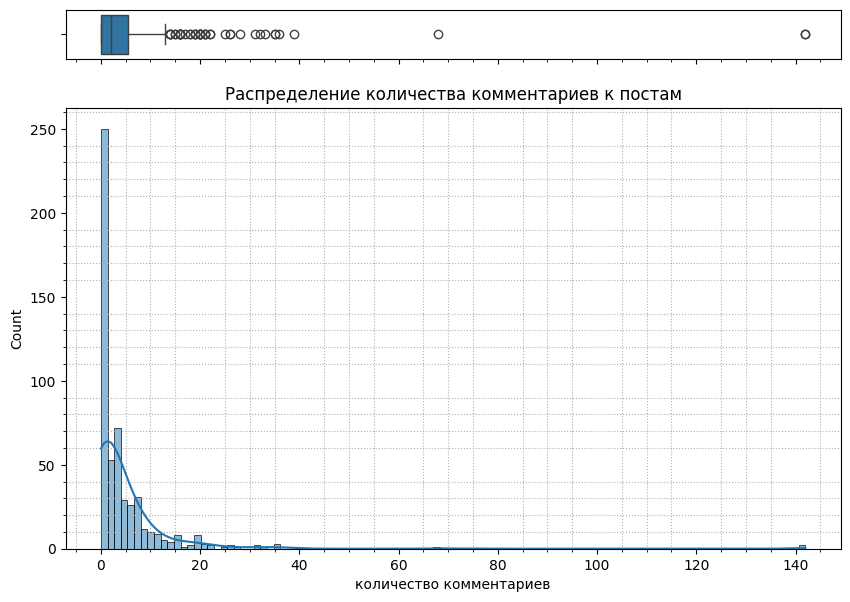

In [33]:
attribute_research(df_emoji, 'comments', 'Распределение количества комментариев к постам', 'количество комментариев')

Хотя наибольшее количество комментариев не слишком сильно уступает максимальному количеству реакций, комментариев к типичному посту разительно меньше. Большое количество постов не комментируется вообще, у половины количество комментариев не превышает двух, третий квартиль - 5,5 комментариев, и только у 1% постов комметариев больше 35 штук.

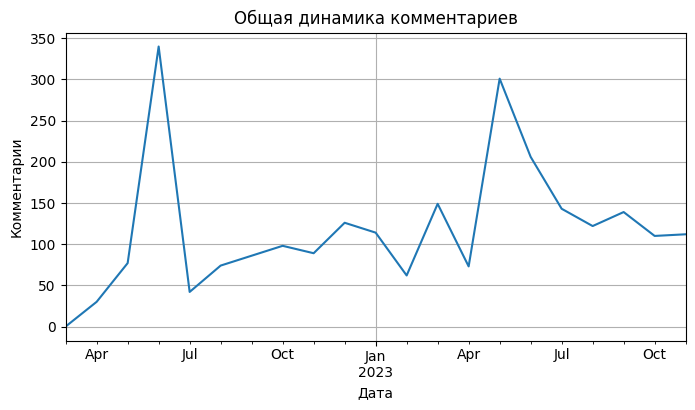

In [34]:
df_emoji[pd.to_datetime(df_emoji['date']) < '12-2023'].groupby(df_emoji['date'].dt.to_period('M')).agg({'comments': 'sum'}).plot(
    xlabel='Дата', ylabel='Комментарии', title='Общая динамика комментариев', grid=True, legend=False, figsize=(8, 4))
plt.show()

Очень ярко выделяются пики в июне 2022 и мае 2023, видимо за них ответственны посты с аномальным количеством комментариев, которые видно на графике распределения. Проверим.

In [35]:
df_emoji[df_emoji['comments'] >= np.percentile(df_emoji['comments'], 99.9)]['date'].unique()

array(['2023-05-29T14:46:11.000000000', '2022-06-09T12:01:39.000000000'],
      dtype='datetime64[ns]')

Предположение подтвердилась - в яркие пики включены посты с аномальным количеством комментариев.

count     539.000000
mean      491.204082
std       401.961486
min         1.000000
5%         42.900000
25%       140.000000
50%       387.000000
75%       802.500000
95%      1276.000000
99%      1478.240000
max      2224.000000
Name: character_count, dtype: float64


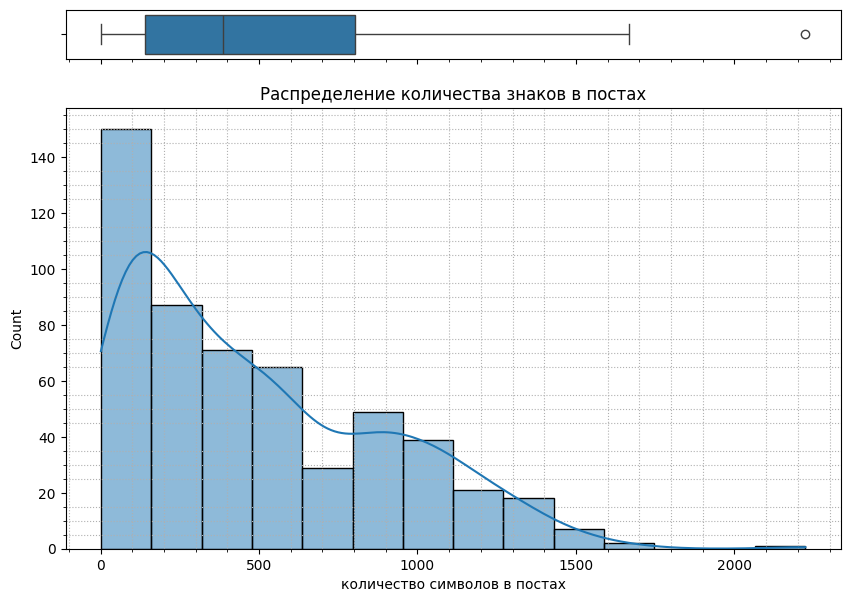

In [36]:
attribute_research(df_emoji, 'character_count', 'Распределение количества знаков в постах', 'количество символов в постах')

Типичный пост в канале состоит из приблизительно 400 символов, только четверть постов длиннее 800 символов. Распределение постов по их размеру относительно равномерно - очень плавно убывает до 99% перцентиля.

count    539.000000
mean       0.037278
std        0.021190
min        0.000000
5%         0.000000
25%        0.024000
50%        0.036000
75%        0.054000
95%        0.071000
99%        0.078000
max        0.119000
Name: difficulty_factor, dtype: float64


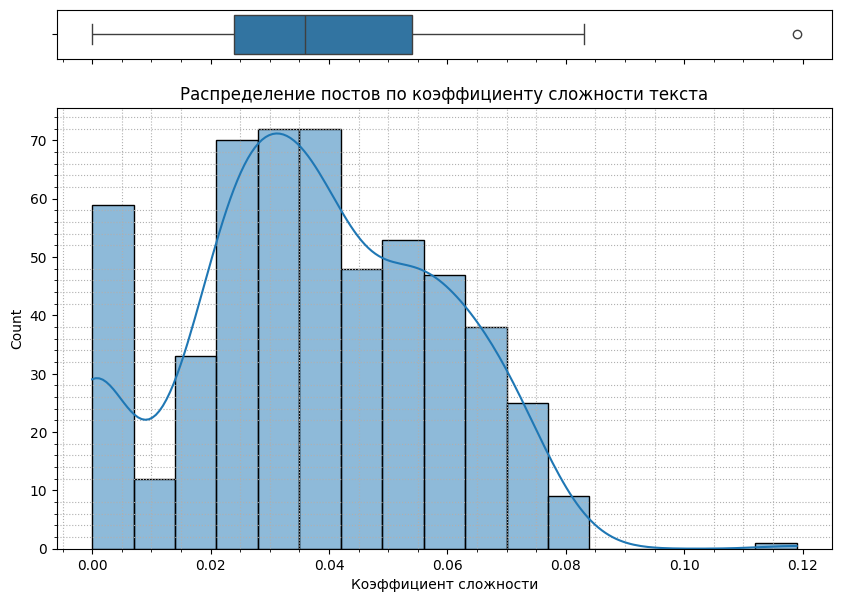

In [37]:
attribute_research(df_emoji, 'difficulty_factor', 'Распределение постов по коэффициенту сложности текста', 'Коэффициент сложности')

Обращает на себя внимание изолированный пик в районе нуля, что говорит о большом количестве максимально простых постов. Остальная часть диаграммы распределена достаточно равномерно в диапазоне коэффициента от 0.02 до 0.08. Посты с большим коэффициентом носят единичный характер.

Построим матрицу корреляций и посмотрим есть ли очевидные зависимости между осноыными метриками: количеством просмотов, количеством реакций, колличеством комментариев, объемом поста и его сложностью.

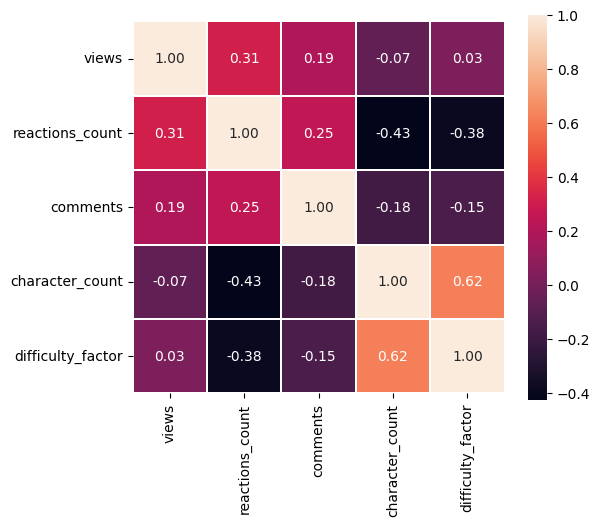

In [38]:
cm = df_emoji[['views', 'reactions_count', 'comments', 'character_count', 'difficulty_factor']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, square=True, fmt='.2f', linewidths=0.1)
plt.show()

Очевидно выраженой сильной корреляции нет между ни одной парой из набора анализируемых параметров. Из ценных наблюдений:
- нет никакой взаимосвязи между количеством просмотров и размером текста поста, а также его сложностью;
- наибольший коэффициент корреляции между количеством реакций на пост и его размером/сложностью, причем зависимость обратная, однако коэффициент слишком мал для чтого, чтобы говорить о четкой причинно-следственной связи, поэтому дополнительно визуализируем распределение на графике рассеяния.

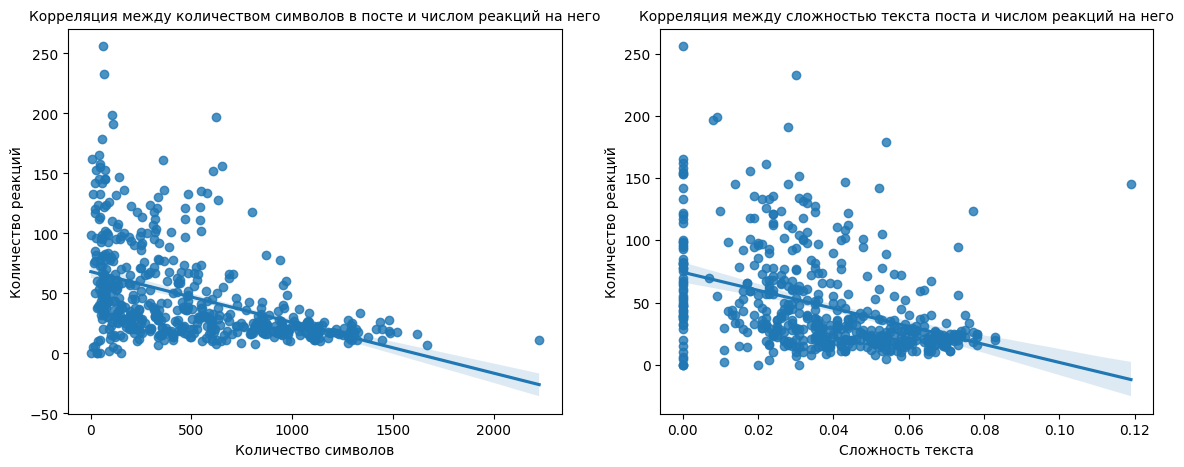

In [39]:
fig, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), gridspec_kw={'width_ratios': (.5, .5)})
sns.regplot(data=df_emoji, x='character_count', y='reactions_count', ax=ax_1)
ax_1.set(xlabel='Количество символов', ylabel='Количество реакций')
ax_1.set_title('Корреляция между количеством символов в посте и числом реакций на него', fontsize=10)
sns.regplot(data=df_emoji, x='difficulty_factor', y='reactions_count', ax=ax_2)
ax_2.set(xlabel='Сложность текста', ylabel='Количество реакций')
ax_2.set_title('Корреляция между сложностью текста поста и числом реакций на него', fontsize=10)
plt.show()

Определенная взаимосвязь просматривается - чем больше символов в посте, тем меньше реакций он собирает. Сохраняется ли такая зависимость между параметрами при изучении отдельных срезов по тематике постов? Для ответа на этот вопрос простроим матрицу корреляций циклом по различным темам. Опросы и розыгрыши не войдут в этот список из-за слишком маленькой выборки попавших в них постов.

Матрица корреляций по постам из темы анонсы


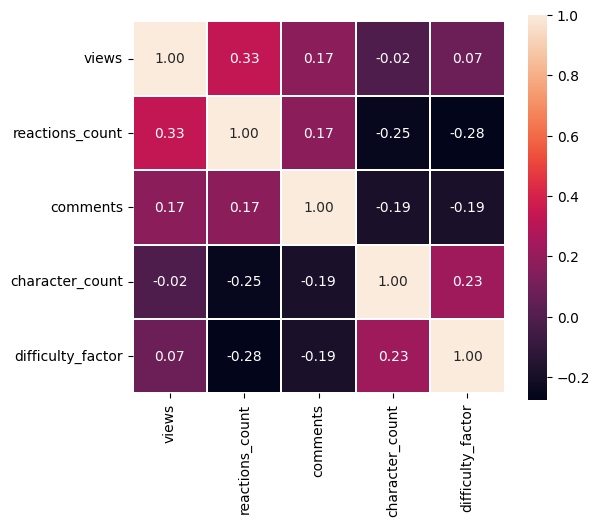

Матрица корреляций по постам из темы новости


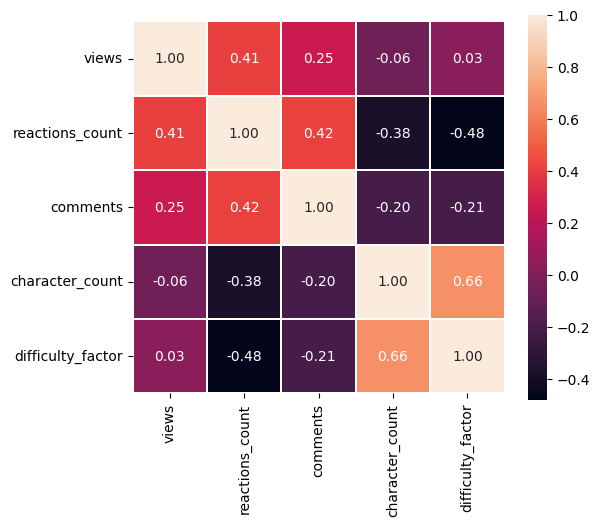

Матрица корреляций по постам из темы локации


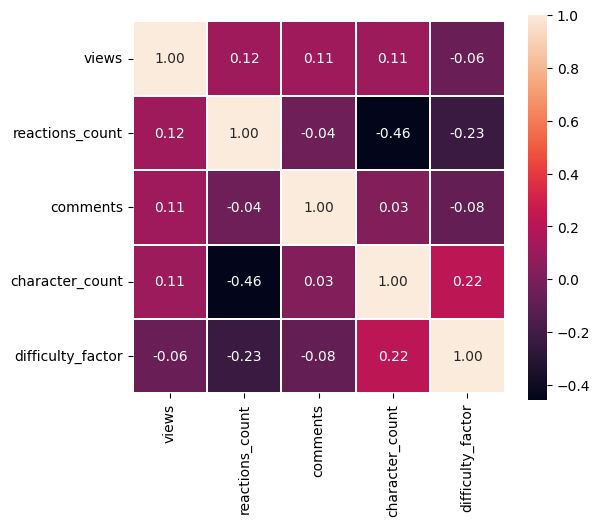

Матрица корреляций по постам из темы университет


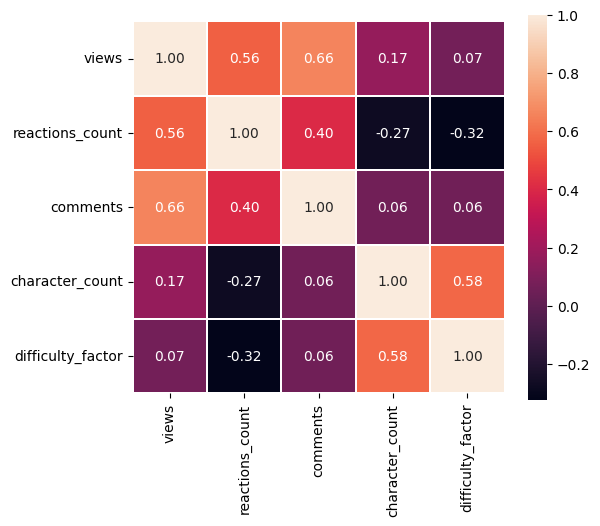

Матрица корреляций по постам из темы вакансии


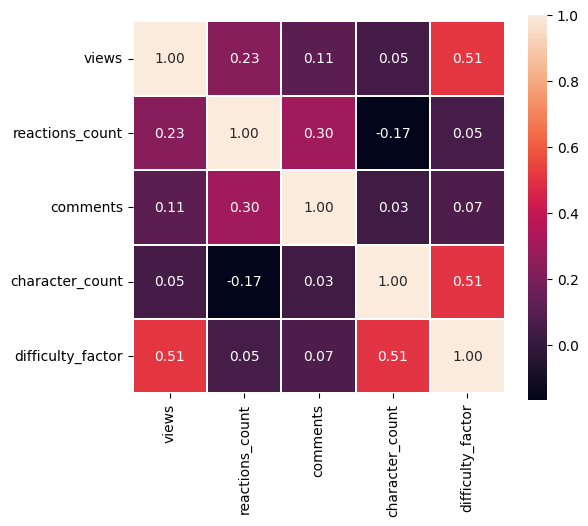

Матрица корреляций по постам из темы for_fun


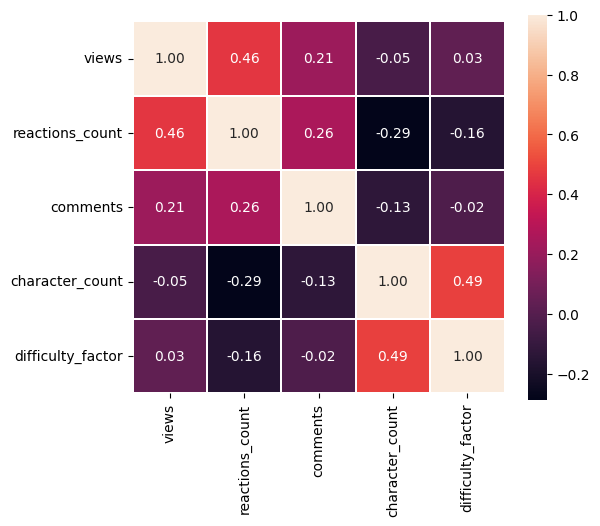

In [40]:
for topic in ['анонсы',
 'новости',
 'локации',
 'университет',
 'вакансии',
 'for_fun']:
    print('Матрица корреляций по постам из темы', topic)
    cm = df_emoji[df_emoji['topic']==topic][['views', 'reactions_count', 'comments', 'character_count', 'difficulty_factor']].corr()
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, square=True, fmt='.2f', linewidths=0.1)
    plt.show()

В приблизительном виде аналогичная общей выборке зависимость сохраняется кроме нескольких исключений. Особенно стоит отметить, что посты про университет Иннополиса имеют очень хорошую корреляцию между просмотрами и количеством реакций и комментариев. Видимо это объясняется высокой активностью студентов, однако у этой тематики выборка самая маленькая из рассмотренных, и это стоит учитывать.

Для оценки качества постов введем дополнительную метрику - ER (коэффициент вовлеченности подписчиков), какой процент от просмотревших пост как-либо отреагировали на него. В нашем случае в качестве реакций будем использовать сумму выставленных эмодзи и написанных комментариев.

In [41]:
df_emoji['ER'] = round((df_emoji['reactions_count'] + (df_emoji['comments']*3)) / df_emoji['views'], 3)
df_emoji['ER'].describe(percentiles=[0.05, 0.25, 0.75, 0.95, 0.99])

count    539.000000
mean       0.015737
std        0.013254
min        0.000000
5%         0.004000
25%        0.006000
50%        0.011000
75%        0.021500
95%        0.040000
99%        0.060620
max        0.109000
Name: ER, dtype: float64

Теперь посмотрим к каким темам относятся посты и наибольшим коэффициентов вовлеченности. Для этого отсортируем посты по убыванию коэффициента вовлеченности подписчиков и выделим 100 наиболее популярных по этой метрике постов.

In [42]:
df_emoji.sort_values(by='ER', ascending=False).iloc[:100]['topic'].value_counts(normalize=True) * 100

новости        36.0
локации        33.0
анонсы         11.0
for_fun        11.0
университет     6.0
розыгрыши       2.0
опросы          1.0
Name: topic, dtype: float64

Наибольший отклик получают новостные посты и посты с фото/видео материалом про город и его окрестности - примерно по трети постов из топ-100 по вовлеченности относятся к одной из двух этих тем. На третьем месте, правда уже с втрое меньшей долей идет развлекательный контент. Пойдем от обратного и посмотрим распределение по темам с минимальным ER-коэффициентом.

In [43]:
df_emoji.sort_values(by='ER', ascending=True).iloc[:100]['topic'].value_counts(normalize=True) * 100

новости        52.0
анонсы         25.0
вакансии       13.0
for_fun         7.0
локации         1.0
университет     1.0
опросы          1.0
Name: topic, dtype: float64

Распределение наименее популярных постов по темам еще менее равномерно. Лидирут, так же как и в топе наиболее популярных, новости. Как мы помним, это наиболее крупная тема, включающая в себя почти 50% всех постов, поэтому не удивительно, что какие-то из них хорошо вовлекают пользователей, а какие-то нет. На втором и третьих местах анонсы мероприятий и вакансии.

Посчитаем количество постов по темам, а также среднее количество просмотров, реакций, комментариев, средний показатель сложности текстов и средний коэффициент вовлеченности. Возьмем медианные значения, так как они менее чувствительны в максимально высоким или низким показателям.

In [44]:
topic = df_emoji.groupby('topic').agg({
    'id': 'count', 'views':'median', 'reactions_count':'median', 'comments':'median', 'difficulty_factor':'median', 'ER':'median'}).sort_values(by='ER', ascending=False)
topic = topic.rename({'id': 'Кол-во постов', 'views': 'Просмотры', 'reactions_count': 'Кол-во реакций', 'comments': 'Кол-во комментариев', 'difficulty_factor': 'Сложность текста'}, axis=1)
topic

Кол-во постов  Просмотры  Кол-во реакций  Кол-во комментариев  \
topic                                                                        
локации                 51     4195.0            90.0                  8.0   
розыгрыши                2     2716.0            74.0                  4.5   
опросы                   2     4044.5            46.5                  3.5   
университет             21     3928.0            59.0                  2.0   
for_fun                 77     3791.0            44.0                  2.0   
анонсы                 112     4134.5            29.0                  2.0   
новости                238     3436.5            26.5                  1.0   
вакансии                36     4422.0            22.5                  3.0   

             Сложность текста     ER  
topic                                 
локации                0.0250  0.033  
розыгрыши              0.0425  0.031  
опросы                 0.0285  0.020  
университет            0.0310  0.017  
for_fun                0.0190  0.015  
анонсы                 0.0380  0.010  
новости                0.0400  0.010  
вакансии               0.0600  0.007

Самое большое количество просмотров в среднем у постов о вакансиях. Второе место по количеству просмотров занимают посты о локациях. У данных постов самый высокий коэффициент вовлеченности, пользователи охотнее всего комментируют их и оставляют реакции.

#### 3.1. Семантический анализ текстов постов и комментариев к ним

Создадим функцию для визуализации облаков слов постов и комментариев к ним.

In [45]:
df_comment = pd.merge(df_comment, df_emoji, left_on='post_id', right_on='id')

In [46]:
# Инициализация стоп-слов
stop_words = set(stopwords.words('russian'))

# Добавление собственных вариантов к списку стоп-слов
custom_stop_words = set(['это', 'еще', 'ещё', 'наиболее', 'млн', 'ия', 'который', 'http', 'всё', 'свой', 'твой', 'весь' 'ваш', 'наш'])

# Объединение стандартных и собственных стоп-слов
stop_words = stop_words.union(custom_stop_words)

# Инициализация лемматизатора и морфологического анализатора
morph = pymorphy2.MorphAnalyzer()
lemmatizer = WordNetLemmatizer()

# Функция для токенизации, лемматизации и удаления стоп-слов
def tokenize_lemmatize_and_filter(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(morph.parse(token)[0].normal_form) for token in tokens]
    return [token for token in lemmatized_tokens if token.lower() not in stop_words and token.isalpha()]

# Функция для визуализации облака слов
def word_cloud(column, title):
  all_text = ' '.join(column.tolist())
  all_text = all_text.lower()
  all_tokens = tokenize_lemmatize_and_filter(all_text)
  text_for_wordcloud = ' '.join(all_tokens)
  wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=400
    ).generate(text_for_wordcloud)
  plt.figure(figsize=(10, 5))
  plt.title(title)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

Визуализируем облако слов для новостных постов.

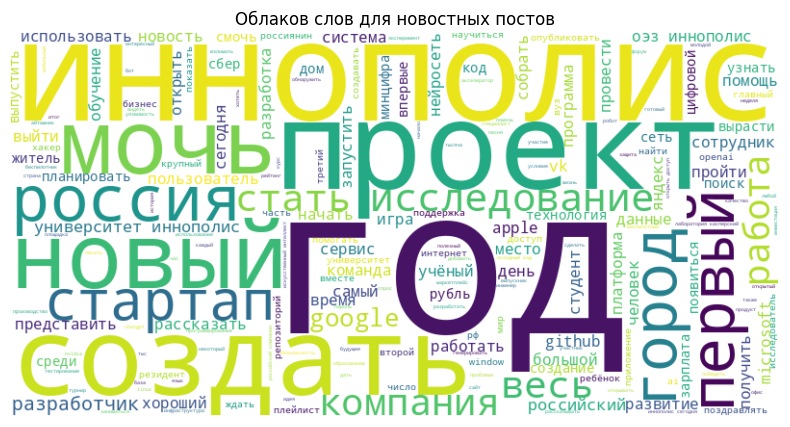

In [47]:
word_cloud(df_emoji.query('topic=="новости"')['text'], 'Облаков слов для новостных постов')

Визуализируем облаков слов для комментариев к новостным постам

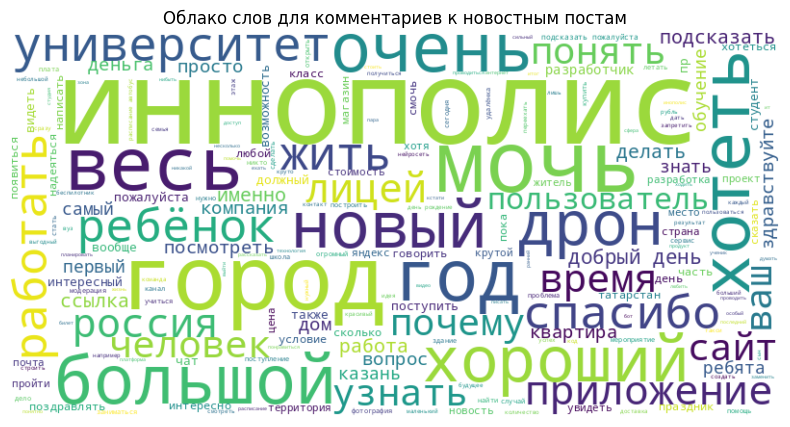

In [48]:
word_cloud(df_comment.query('topic=="новости"')['text_comment'], 'Облако слов для комментариев к новостным постам')

Поскольку новостных постов больше всего в канале, сложно выявить какие-то тенденции в этой тематике. Попробуем посмотреть на облака слов самых популярных и самых непопулярных постов этой тематики

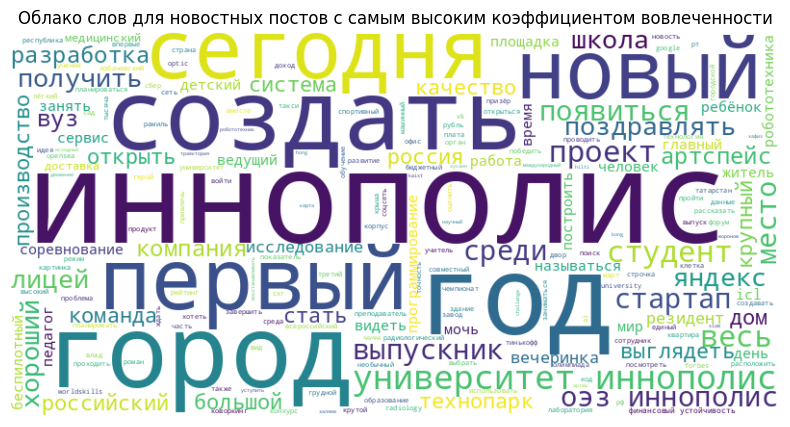

In [49]:
word_cloud(df_emoji.sort_values(by='ER', ascending=False).iloc[:100].query('topic=="новости"')['text'],
           'Облако слов для новостных постов с самым высоким коэффициентом вовлеченности')

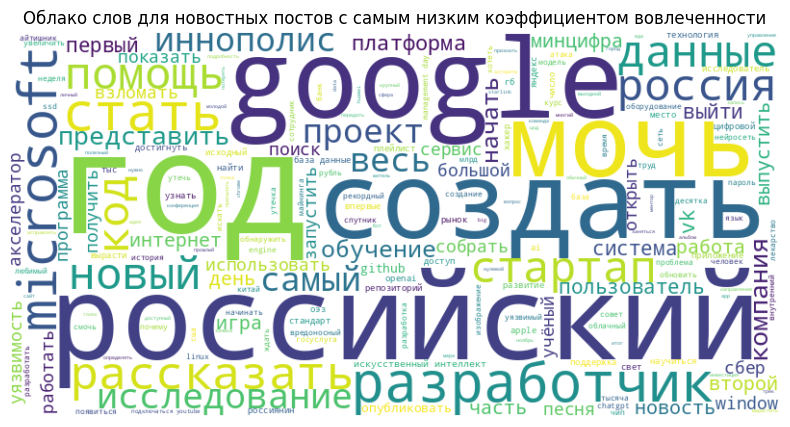

In [50]:
word_cloud(df_emoji.sort_values(by='ER', ascending=True).iloc[:100].query('topic=="новости"')['text'],
           'Облако слов для новостных постов с самым низким коэффициентом вовлеченности')

В облаке слов наиболее популярных новостных постов выделяются слова "город", "университет", "новый", "первый", "выпускник", "студент". В облаке слов наименее популярных постов выделяются слова "google", "microsoft", "стартап", "данные", "код". Можем предположить, что подписчики канала охотнее реагируют на новостные посты о жизни города, чем на посты, относящиеся к сфере IT.

Визуализируем облака слов для постов с тематикой "Локации" и комментариев к ним.

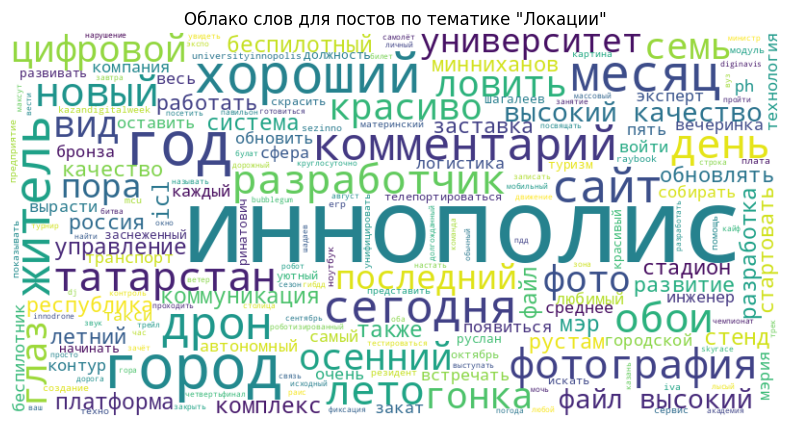

In [51]:
word_cloud(df_emoji.query('topic=="локации"')['text'], 'Облако слов для постов по тематике "Локации"')

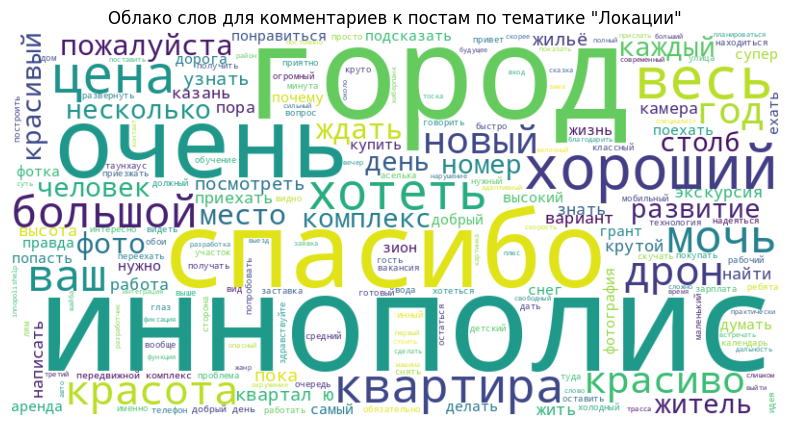

In [52]:
word_cloud(df_comment.query('topic=="локации"')['text_comment'], 'Облако слов для комментариев к постам по тематике "Локации"')

В комментариях к постам о локациях выделяются слова "красота", "хороший", "красиво", "город", "спасибо", что может говорить о удовлетворенности качеством контента.

Также визуализируем облака слов для постов с тематикой "Университет" и комментариев к ним.

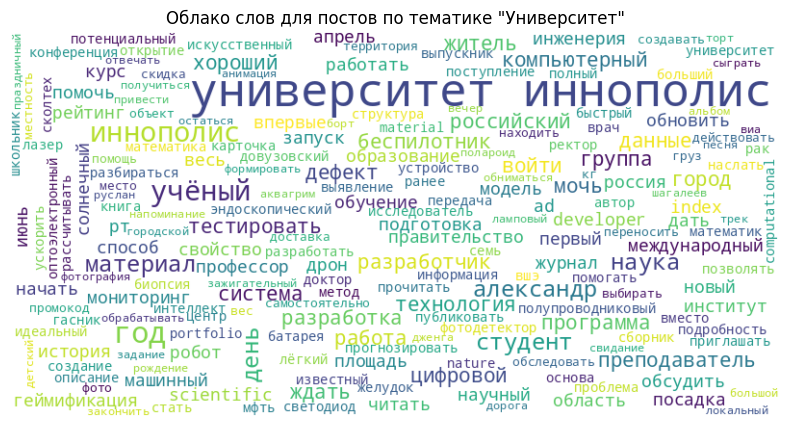

In [53]:
word_cloud(df_emoji.query('topic=="университет"')['text'], 'Облако слов для постов по тематике "Университет"')

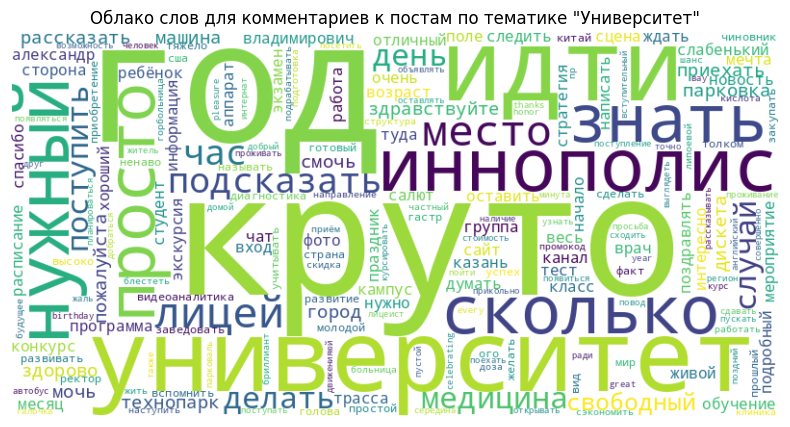

In [54]:
word_cloud(df_comment.query('topic=="университет"')['text_comment'], 'Облако слов для комментариев к постам по тематике "Университет"')

В облаке слов для комментариев к постам об университете сильно выделяется слово "круто", что также говорит об удовлетворенности контентом.

##### 3.1.1. Углубленный семантический анализ комментариев к постам

Изучим комментарии более подробно, а также попробуем выделить и охарактеризовать посты, индуцирующие высокий интерес к городу.

Для начала посчитаем длинну каждого комментария. Для этого создадим новое поле `comment_char_cnt`,  после чего посмотрим на распределением количества символов в комментариях к постам.

In [55]:
df_comment['comment_char_cnt'] = df_comment['text_comment'].apply(lambda x: len(x))
df_comment['comment_char_cnt'].describe(percentiles=[0.05, 0.25, 0.75, 0.95, 0.99])

count    2511.000000
mean       56.914377
std       131.640608
min         0.000000
5%          0.000000
25%         4.000000
50%        27.000000
75%        63.000000
95%       190.000000
99%       504.800000
max      3606.000000
Name: comment_char_cnt, dtype: float64

Распределение крайне неравномерное - половина оставленных комментариев не длиннее 27 символов, 99% перцентиль уже более 500, а максимальное значение больше 3 тысяч знаков, что даже больше размера самого большого поста из выборки.Поэтому средняя и медиана отличаютя более чем вдвое. Также встречаются комментарии с длинной равной нулю, ручная проверка показала, что такие комментарии содержат вложенные gif-анимации. Используя информацию о размере каждого отдельно комментария создадим в основной таблице поле `avg_comment_char` с информацией о средней длине оставленных к посту комментариев.

In [56]:
df_comment['comment_char_cnt']
df_emoji = df_emoji.merge(df_comment.groupby('post_id')['comment_char_cnt'].mean().round(1).rename('avg_comment_char'),
                          left_on='id', right_on='post_id', how='left')

count     338.000000
mean       63.411243
std        91.838483
min         0.000000
5%          7.725000
25%        26.425000
50%        44.050000
75%        71.300000
95%       149.635000
99%       359.520000
max      1203.000000
Name: avg_comment_char, dtype: float64


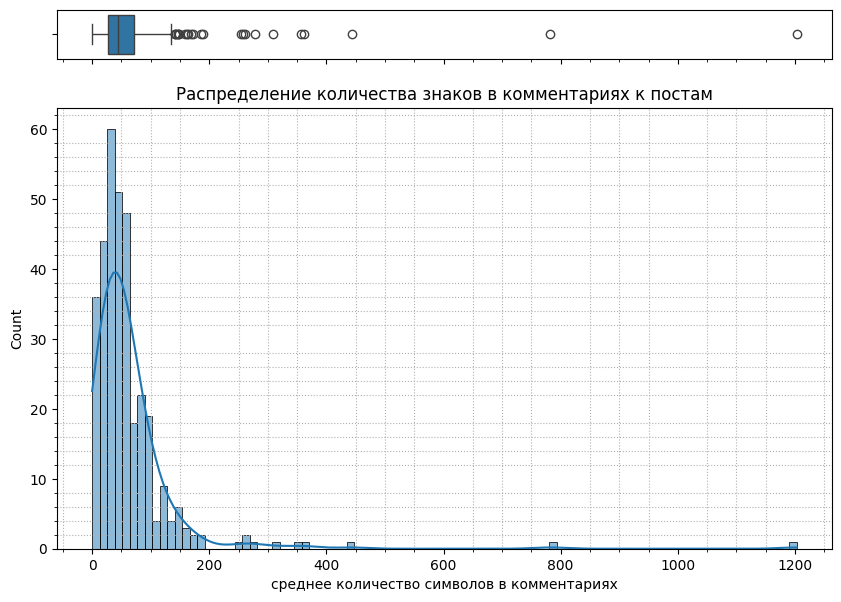

In [57]:
# Посмотрим на распределение полученной величины
attribute_research(df_emoji, 'avg_comment_char', 'Распределение количества знаков в комментариях к постам', 'среднее количество символов в комментариях')

Медиана практически совпадает с пиком гистрограммы, средний размер комментария стал ощутимо ближе к медиане, а основаная масса комментариев содержит не более 200 символов, выбросы за это значение носят единичный характер. Посмотрим к каким темам пишут самые короткие и самые длинные комментарии.

In [58]:
df_emoji.sort_values(by='avg_comment_char', ascending=False).iloc[:100]['topic'].value_counts(normalize=True).head(5) * 100

новости        48.0
анонсы         22.0
вакансии       10.0
for_fun         9.0
университет     6.0
Name: topic, dtype: float64

В топе постов с самыми длинными комментариями практические каждое второе место занимают новости, каждый пятый пост про анонсы и примерно по 10% у вакансий и развлекательного контента. Сравним эти цифры с распределением тем по количеству постов, а не их средней длине.

In [59]:
df_emoji.sort_values(by='comments', ascending=False).iloc[:100]['topic'].value_counts(normalize=True).head(5) * 100

новости     32.0
локации     26.0
анонсы      18.0
for_fun     12.0
вакансии     7.0
Name: topic, dtype: float64

Структура отличается и отличается сильно, значит корреляции с количеством комментариев к посту с их средней длинной нет.


In [60]:
df_emoji.sort_values(by='avg_comment_char').iloc[:100]['topic'].value_counts(normalize=True).head(5) * 100

новости        29.0
for_fun        25.0
локации        24.0
анонсы         15.0
университет     3.0
Name: topic, dtype: float64

Распределение самых лаконично комментируемых постов другое и куда более равномерно, в топ-3 с незначительным отрывом от вездесущих новостей занимают посты из темы локации. Теперь займемся семантическим анализом текстов комментариев: нам необходимо найти посты, побуждающие людей переехать, или хотя бы приехать в Иннополис. Для этого проверим тексты комментариев на вхождение ключевых слов при помощи регулярных выражений, после чего посмотрим к каким постам они отностся. Зададим переменную `regex_pattern` с паттерном для поиска и зададим функцию `find_matches` при помощи которой будем отмечать нужные комментарии.

In [61]:
regex_pattern = r'\b(?:переезжа(?:ть|ю)|приедем|едем|рассматриваю\s+переезд|задумалась\s+о\s+переезде|поеха(?:ть|ю)|приеха(?:ть|ал(?:а)?)|перееха(?:ть|ал(?:а)?)|хочу\s+к\s+вам|хочу\s+посмотреть|съезди(?:ть|м)|люблю\s+приезжать|нужно\s+приезжать)\b'

In [62]:
# функция для поиска совпадений с регулярным выражением в столбце text_comment
def find_matches(text):
    matches = re.findall(regex_pattern, text.lower())
    return bool(matches)

# применение функции к столбцу text_comment и создание нового столбца с результатами
df_comment['has_match'] = df_comment['text_comment'].fillna('').apply(find_matches)

Отметим в новом поле `targeted_comments` посты, к которым относятся найденные комментарии, после чего посчитаем их колличество и опишем, чем такие посты характеризуются.

In [63]:
df_emoji['targeted_comments'] = df_emoji['id'].isin(list(df_comment.query('has_match == True')['post_id'].unique()))
df_emoji.query('targeted_comments == True').shape[0]

33

In [64]:
# посмотрим как выделенные посты распределяются по темам
df_emoji.query('targeted_comments == True')['topic'].value_counts()

локации        9
новости        9
анонсы         7
for_fun        5
вакансии       2
университет    1
Name: topic, dtype: int64

In [65]:
# выведем ключевые метрики для среза из целевых постов
df_emoji.query('targeted_comments == True').agg({'views': 'mean', 'reactions_count': 'mean', 'comments': 'mean', 'character_count': 'mean', 'difficulty_factor': 'mean', 'ER': 'mean'})

views                4607.121212
reactions_count        79.727273
comments               18.424242
character_count       363.333333
difficulty_factor       0.030879
ER                      0.031697
dtype: float64

Таким образом типовой пост, под которым оставляют целевые комментарии:
*   довольно популярный - имеет количество просмотров выше 75% перцентиля
*   собирает значительно больше реакций чем средний пост в канале
*   очень комментируемый, входит в верхние 5% постов по их количеству
*   медианный по размеру, не слишком большой, но и не короткий
*   написан довольно просто, без излишней пунктуации
*   обладает очень высоким коэффциентом вовлеченности

#### 3.2. Анализ времени публикаций

Изучим, в какие дни недели и какое время суток обычно публикуются посты.

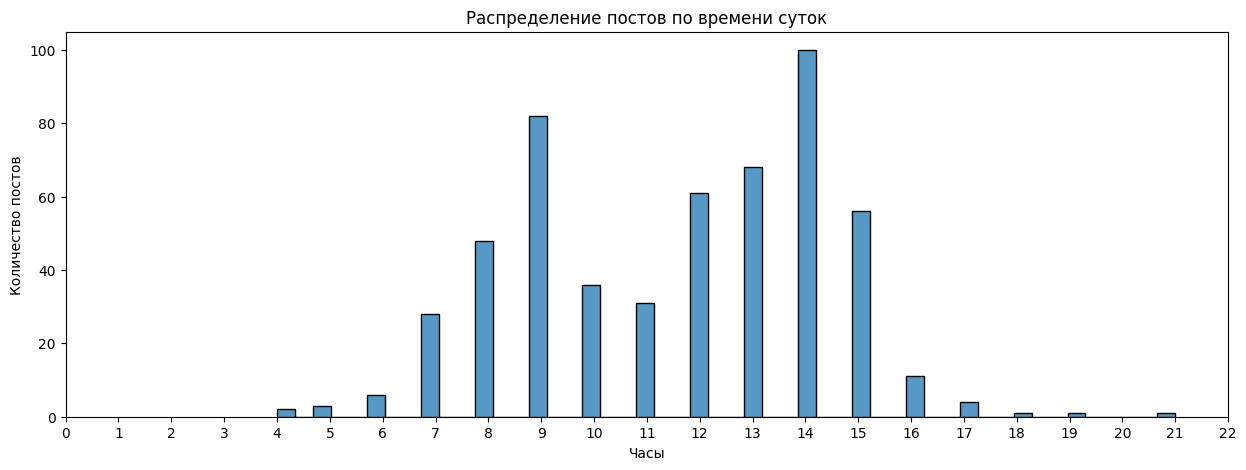

In [66]:
plt.figure(figsize=(15, 5))
sns.histplot(df_emoji['date'].dt.hour, bins=50)
plt.title('Распределение постов по времени суток')
plt.xticks(range(0, 23))
plt.xlabel('Часы')
plt.ylabel('Количество постов')
plt.show()

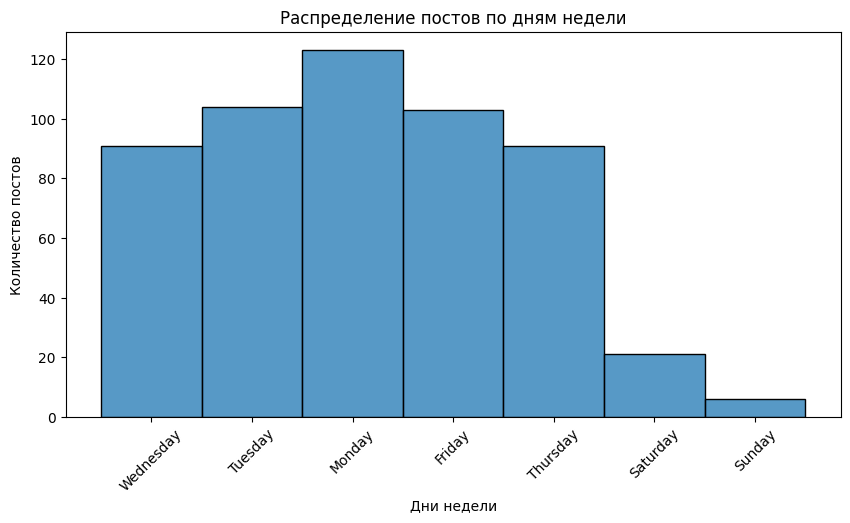

In [67]:
plt.figure(figsize=(10, 5))
sns.histplot(df_emoji['date'].dt.day_name(), bins=500)
plt.title('Распределение постов по дням недели')
plt.xticks(range(0, 7))
plt.xlabel('Дни недели')
plt.xticks(rotation=45)
plt.ylabel('Количество постов')
plt.show()

Основная часть постов публикуется в будние дни (чаще всего по понедельникам, реже всего по средам) с 7:00 до 15:00. Теперь посмотрим есть ли разница с наиболее просматриваемыми постами (топ-200).

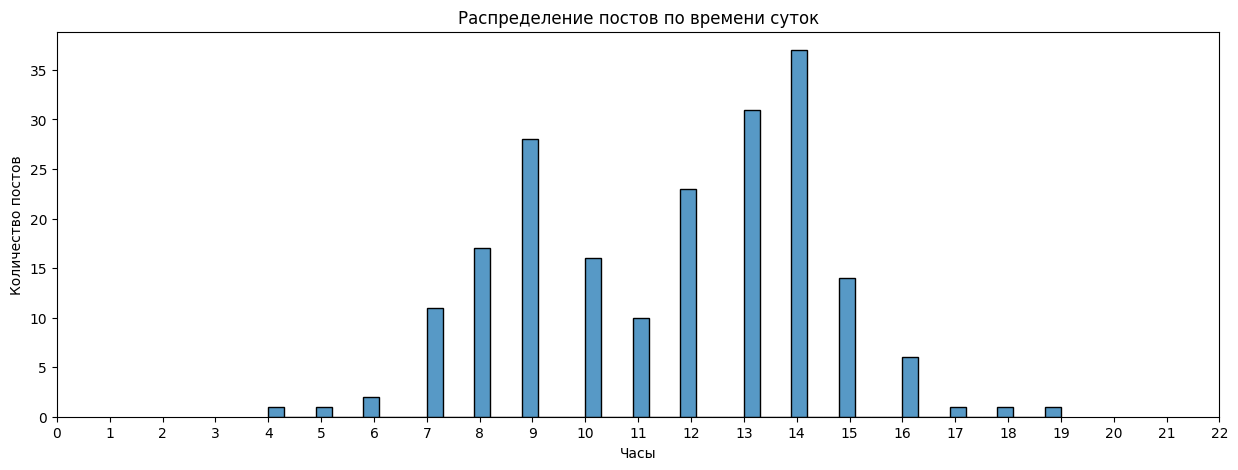

In [68]:
plt.figure(figsize=(15, 5))
sns.histplot(df_emoji.sort_values(by='views', ascending=False).head(200)['date'].dt.hour, bins=50)
plt.title('Распределение постов по времени суток')
plt.xticks(range(0, 23))
plt.xlabel('Часы')
plt.ylabel('Количество постов')
plt.show()

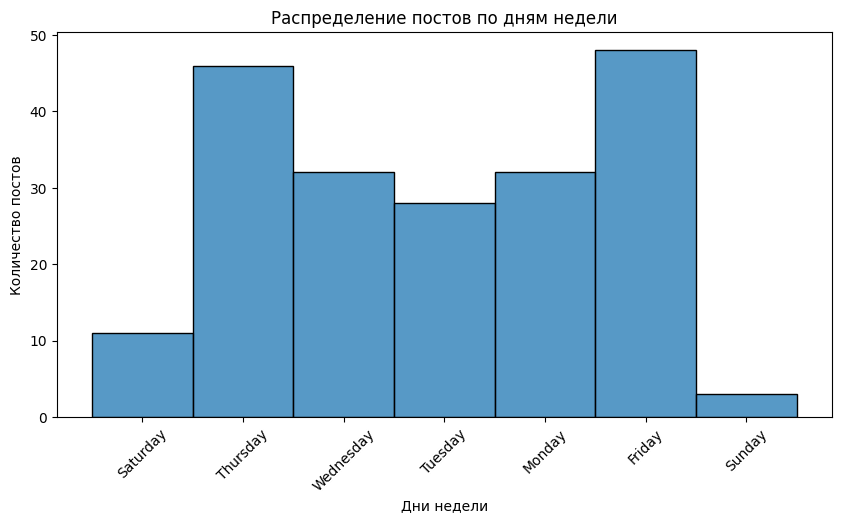

In [69]:
plt.figure(figsize=(10, 5))
sns.histplot(df_emoji.sort_values(by='views', ascending=False).head(200)['date'].dt.day_name(), bins=500)
plt.title('Распределение постов по дням недели')
plt.xticks(range(0, 7))
plt.xlabel('Дни недели')
plt.xticks(rotation=45)
plt.ylabel('Количество постов')
plt.show()

По времени публикации значимой разницы нет, а вот в разрезе по дням неделе различия присустсвуют: хорошо посматриваемые посты обычно публикую в конце рабочей недели, в четверг и пятницу. Теперь проверим зависимость коэффициента вовлеченности от времени публикации.

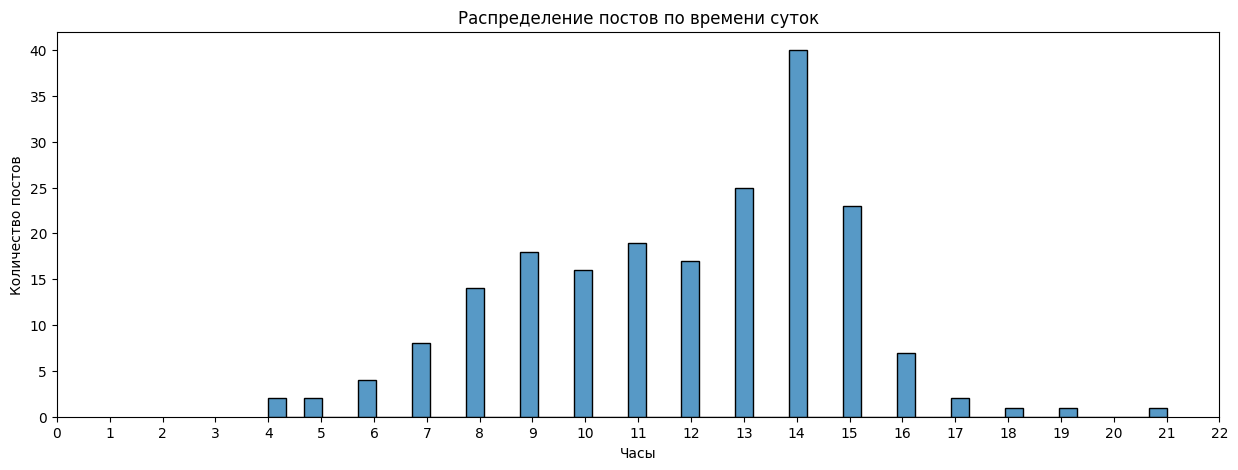

In [70]:
plt.figure(figsize=(15, 5))
sns.histplot(df_emoji.sort_values(by='ER', ascending=False).head(200)['date'].dt.hour, bins=50)
plt.title('Распределение постов по времени суток')
plt.xticks(range(0, 23))
plt.xlabel('Часы')
plt.ylabel('Количество постов')
plt.show()

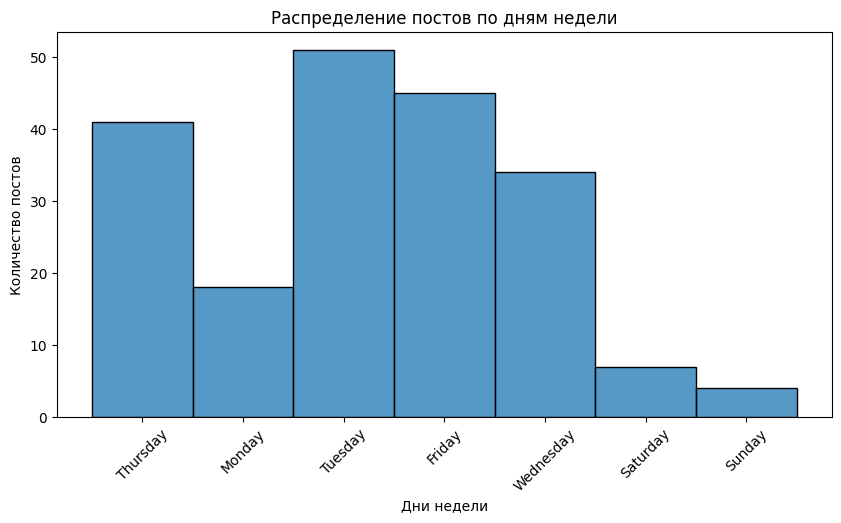

In [71]:
plt.figure(figsize=(10, 5))
sns.histplot(df_emoji.sort_values(by='ER', ascending=False).head(200)['date'].dt.day_name(), bins=500)
plt.title('Распределение постов по дням недели')
plt.xticks(range(0, 7))
plt.xlabel('Дни недели')
plt.xticks(rotation=45)
plt.ylabel('Количество постов')
plt.show()

Временная структура уже изменилась, количество плавно нарастает с утра к 14-00, после чего резко идет на спад. После 16 часов постов с высоким ER уже практически нет. По дням недели лидируют вторник, четверг и пятница, серьезно проседает понедельник, а выходные дни явные аутсайдеры.

Посмотрим, когда пользователи чаще всего оставляют комментарии к постам. Построим гистограммы распредления комментариев по дням недели и времени суток

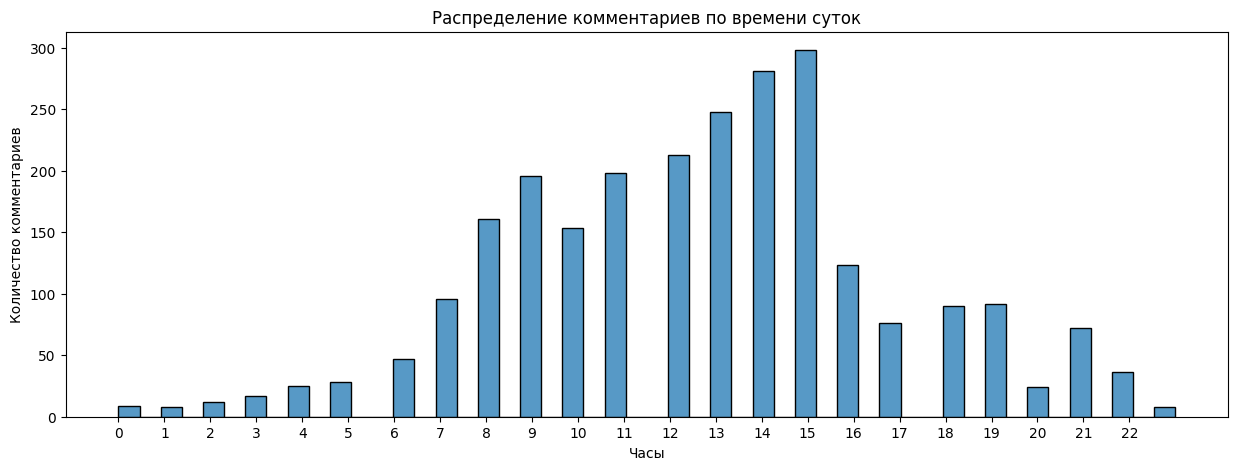

In [72]:
plt.figure(figsize=(15, 5))
sns.histplot(df_comment['date_comment'].dt.hour, bins=50)
plt.title('Распределение комментариев по времени суток')
plt.xticks(range(0, 23))
plt.xlabel('Часы')
plt.ylabel('Количество комментариев')
plt.show()

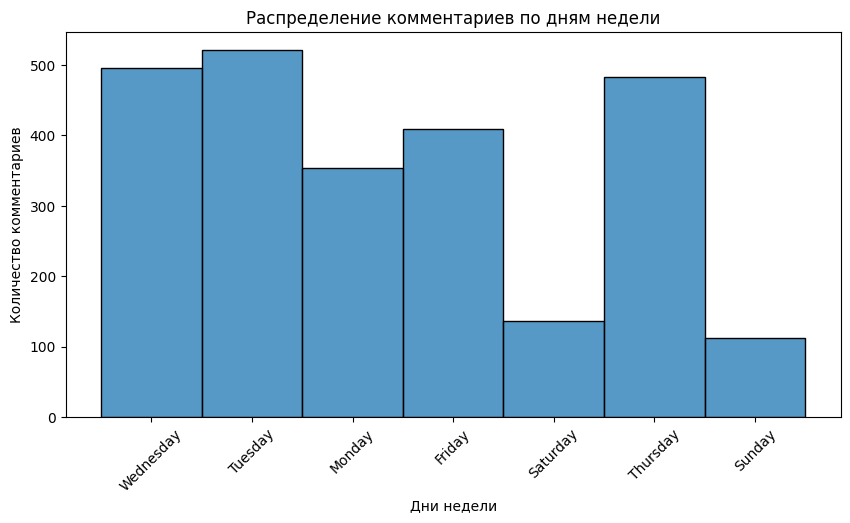

In [73]:
plt.figure(figsize=(10, 5))
sns.histplot(df_comment['date_comment'].dt.day_name(), bins=500)
plt.title('Распределение комментариев по дням недели')
plt.xticks(range(0, 7))
plt.xlabel('Дни недели')
plt.xticks(rotation=45)
plt.ylabel('Количество комментариев')
plt.show()

Подписчики наиболее активно комментируют посты в середине недели (со вторника по четверг) с 8 утра до 15 часов дня. Из чего можно сделать вывод, что данное время является оптимальным для публикации постов.

Посмотрим, в течение какого времени пользователи обычно оставляют комментарии к постам. Для этого создадим новый столбец, в котором посчитаем разницу между датой и временем публикации поста и датой и временем публикации комментария.

In [74]:
df_comment['lifetime'] = df_comment['date_comment'] - df_comment['date']
df_comment['lifetime'].describe()

count                          2511
mean      2 days 13:30:41.240143369
std      14 days 14:03:25.078982315
min                 0 days 00:00:05
25%                 0 days 00:24:51
50%                 0 days 03:54:37
75%          1 days 02:02:49.500000
max               452 days 05:54:11
Name: lifetime, dtype: object

Исходя из данных, мы видим, что 75% всех комментариев были оставлены в течение первых 26 часов с момента публикации поста. Соответственно, можем предположить, что в большинстве случаев пользователи комментируют посты в течение одного дня (50% комментариев были созданы в течение первых 4 часов с момента публикации поста).

#### 3.3. Анализ реакций на сообщения

Теперь перейдем к более подробному анализу реакций. В данных имеется их структура в разрезе по конкретным эмодзи для каждого поста. Для общего анализа целесообразно создать в датафрейме три новых поля: самый популярный эмодзи, количество эмодзи с положительной, и с отрицательной коннотацией. Для двух последних необходимо собрать список всех встречающихся в данных эмодзи и сформировать словарь, который будет делить их на позитивные и негативные. Для этого сформируем промежуточную таблицу `parsed_emoji` и зададим функцию `parse_reactions`, при помощи которой заполним её.

In [75]:
parsed_emoji = pd.DataFrame(columns=['id', 'emoji', 'cnt_emoji'])

# Функция для парсинга словарей в отдельные колонки и заполнения новой таблицы
def parse_reactions(row):
    parsed_rows = []
    try:
        reactions = ast.literal_eval(row['reactions'])
        for reaction in reactions['results']:
            emoji = reaction['reaction'].get('emoticon', None)
            count = reaction['count']
            parsed_rows.append({'id': row['id'], 'emoji': emoji, 'cnt_emoji': count})
    except Exception as e:
        print(f"Error: {e}")
    return parsed_rows

In [76]:
# применение функции к каждой строке и заполнение таблицы parsed_emoji
for index, row in df_emoji.iterrows():
    parsed_rows = parse_reactions(row)
    parsed_emoji = parsed_emoji.append(parsed_rows, ignore_index=True)

<ipython-input-76-ca209c583ff4>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parsed_emoji = parsed_emoji.append(parsed_rows, ignore_index=True)
<ipython-input-76-ca209c583ff4>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parsed_emoji = parsed_emoji.append(parsed_rows, ignore_index=True)
<ipython-input-76-ca209c583ff4>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parsed_emoji = parsed_emoji.append(parsed_rows, ignore_index=True)
<ipython-input-76-ca209c583ff4>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parsed_emoji = parsed_emoji.append(parsed_rows, ignore_index=True)
<ipython-input-76-ca209c583ff4>:4: FutureWarning: Th

Error: invalid syntax (<unknown>, line 0)


<ipython-input-76-ca209c583ff4>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parsed_emoji = parsed_emoji.append(parsed_rows, ignore_index=True)
<ipython-input-76-ca209c583ff4>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parsed_emoji = parsed_emoji.append(parsed_rows, ignore_index=True)
<ipython-input-76-ca209c583ff4>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parsed_emoji = parsed_emoji.append(parsed_rows, ignore_index=True)
<ipython-input-76-ca209c583ff4>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parsed_emoji = parsed_emoji.append(parsed_rows, ignore_index=True)
<ipython-input-76-ca209c583ff4>:4: FutureWarning: Th

Error: invalid syntax (<unknown>, line 0)


<ipython-input-76-ca209c583ff4>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parsed_emoji = parsed_emoji.append(parsed_rows, ignore_index=True)
<ipython-input-76-ca209c583ff4>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parsed_emoji = parsed_emoji.append(parsed_rows, ignore_index=True)
<ipython-input-76-ca209c583ff4>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parsed_emoji = parsed_emoji.append(parsed_rows, ignore_index=True)
<ipython-input-76-ca209c583ff4>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parsed_emoji = parsed_emoji.append(parsed_rows, ignore_index=True)
<ipython-input-76-ca209c583ff4>:4: FutureWarning: Th

Error: invalid syntax (<unknown>, line 0)
Error: invalid syntax (<unknown>, line 0)
Error: invalid syntax (<unknown>, line 0)


<ipython-input-76-ca209c583ff4>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parsed_emoji = parsed_emoji.append(parsed_rows, ignore_index=True)
<ipython-input-76-ca209c583ff4>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parsed_emoji = parsed_emoji.append(parsed_rows, ignore_index=True)
<ipython-input-76-ca209c583ff4>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parsed_emoji = parsed_emoji.append(parsed_rows, ignore_index=True)
<ipython-input-76-ca209c583ff4>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parsed_emoji = parsed_emoji.append(parsed_rows, ignore_index=True)
<ipython-input-76-ca209c583ff4>:4: FutureWarning: Th

Преобразуем счетчик количества реакций и id поста в целочисленный тип даннных и заменим нераспознанные эмодзи на текст `нестандартный эмодзи`. После этого найдем количество уникальных реакций, а также посчитаем их частотность.

In [77]:
parsed_emoji[['id', 'cnt_emoji']] = parsed_emoji[['id', 'cnt_emoji']].astype('int')
parsed_emoji['emoji'] = parsed_emoji['emoji'].fillna('нестандартный эмодзи')

In [78]:
print('Количество уникальных реакций, встречающихся в постах канала:', parsed_emoji.groupby('emoji')['cnt_emoji'].sum().sort_values(ascending=False).nunique())
print('Общее количество оставленных реакций:', parsed_emoji.groupby('emoji')['cnt_emoji'].sum().sum())
parsed_emoji.groupby('emoji')['cnt_emoji'].sum().sort_values(ascending=False)

Количество уникальных реакций, встречающихся в постах канала: 39
Общее количество оставленных реакций: 25541


emoji
🔥                       6189
👍                       5425
❤                       5247
❤‍🔥                     1662
👏                       1039
🤣                        930
😍                        765
🎉                        552
💯                        532
🤔                        449
😁                        348
🥰                        239
🍾                        235
🐳                        211
💘                        208
👎                        198
🏆                        195
🌚                        187
👀                        171
👌                        124
🆒                        118
👨‍💻                       73
😐                         69
⚡                         52
нестандартный эмодзи      49
🦄                         44
🍓                         40
☃                         31
🤗                         26
🎅                         22
✍                         20
🤝                         19
👾                         17
🙏                         13
🗿       

Всего на канале используются 39 эмодзи и среди них с большим отрывом лидируют эмодзи с однозначной позитивной коннотацией - сумма по топ-3 реакций превышает сумму всех остальных реакций вместе взятых, аудитория канала реагирует на посты явно позитивно. Ручная проверка постов показала, что под пропусками скрывается кастомный эмодзи заката, повторяющий аватар канала. Посмотрим как давно он появился и динамику популярности в структуре реакций на посты.

Создадим словарь `emoji_dict`, который распределяет все эмодзи на положительные, нейтральные, отрицательные и нестандартные, а также новые колонки в основной таблице:
- `top_emoji`: самая популярная реакция на пост;
- `pos_emoji`: количество позитивных реакций на пост;
- `neg_emoji`: количество негативных реакций на пост;
- `ino_emoji`: количество реакций на пост с использованием собственных эмодзи Иннополиса

In [79]:
emoji_dict = {
    'pos_emoji': ['🔥', '👍', '❤', '❤‍🔥', '👏', '🤣', '😍', '🎉', '💯', '😁', '🥰', '🍾', '💘', '🏆', '👌', '🆒', '🤗', '🤝', '🙏', '🎄', '🎅', '😎', '🤓', '🍓'],
    'neg_emoji': ['👎'],
    'neutral_emoji': ['🤔', '🐳', '🌚', '👀', '👨‍💻', '😐', '⚡', '🦄', '☃', '✍', '👾', '🗿', '😈', '👻'],
    'ino_emoji': 'нестандартный эмодзи'
}

In [80]:
df_emoji = df_emoji.merge(parsed_emoji.groupby('id')['cnt_emoji'].idxmax().rename('top_emoji').apply(lambda x: parsed_emoji.loc[x, 'emoji']), on='id', how='left')
df_emoji = df_emoji.merge(parsed_emoji[parsed_emoji['emoji'].isin(emoji_dict['pos_emoji'])].groupby('id')['cnt_emoji'].sum().rename('pos_emoji_cnt'),
                          on='id', how='left')
df_emoji = df_emoji.merge(parsed_emoji[parsed_emoji['emoji'].isin(emoji_dict['neg_emoji'])].groupby('id')['cnt_emoji'].sum().rename('neg_emoji_cnt'),
                          on='id', how='left')
df_emoji = df_emoji.merge(parsed_emoji[parsed_emoji['emoji'] == 'нестандартный эмодзи'].groupby('id')['cnt_emoji'].sum().rename('ino_emoji_cnt'),
                          on='id', how='left')

Заменим в новых полях пропущенные значения на нули и тип данных на int, после чего найдем дату первого появления собственного эмодзи канала.

In [81]:
df_emoji[['pos_emoji_cnt', 'neg_emoji_cnt', 'ino_emoji_cnt']] = df_emoji[['pos_emoji_cnt', 'neg_emoji_cnt', 'ino_emoji_cnt']].fillna(0).astype('int')
df_emoji.query('ino_emoji_cnt > 0')['date'].min()

Timestamp('2023-11-30 14:05:01')

Собственный эмодзи появился всего за неделю до наиболее поздней даты из датафрейма, в выборку вошло буквально несколько постов, чего явно недостаточно для анализа динамики его использования. Визуализируем как менялась реакция аудитории канала на его посты, для этого построим линейный график, показывающий сгруппированное понедельно среднее соотношение позитивных реакций к негативным.

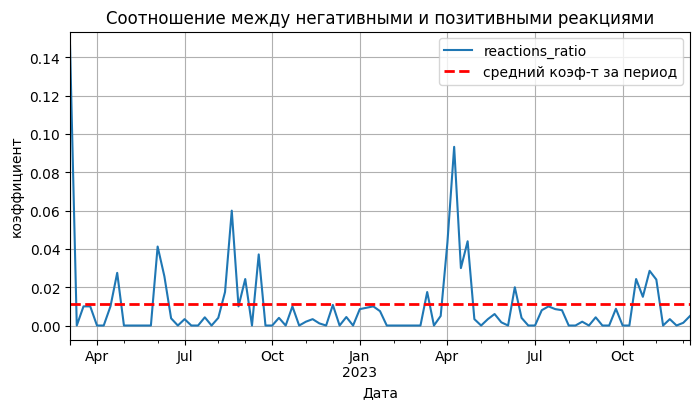

In [82]:
df_emoji['reactions_ratio'] = round(df_emoji['neg_emoji_cnt'] / (df_emoji['pos_emoji_cnt'] + df_emoji['ino_emoji_cnt']), 2)

df_emoji.groupby(df_emoji['date'].dt.to_period('W')).agg({'reactions_ratio': 'mean'}).plot(
    xlabel='Дата', ylabel='коэффициент', title='Соотношение между негативными и позитивными реакциями', grid=True, figsize=(8, 4), label='средний коэф-т за месяц')
plt.axhline(y=df_emoji['reactions_ratio'].mean(), color='r', label='средний коэф-т за период', linestyle='--', linewidth=2)
plt.legend()
plt.show()

На графике отчетливо выделяется несколько пиков с недовольством аудитории постами. Выделим топ-100 постов с максимальным количеством как позитивных, так и негативных реакций и посмотрим их распределение их структуры по тематике.

In [83]:
df_emoji.sort_values(by='pos_emoji_cnt').iloc[:100]['topic'].value_counts(normalize=True).head(5) * 100

новости        60.0
анонсы         18.0
for_fun        12.0
вакансии        7.0
университет     2.0
Name: topic, dtype: float64

In [84]:
df_emoji.sort_values(by='neg_emoji_cnt').iloc[:100]['topic'].value_counts(normalize=True).head(5) * 100

новости     44.0
for_fun     20.0
анонсы      19.0
локации      9.0
вакансии     5.0
Name: topic, dtype: float64

Тематики таких постов хорошо коррелируют с тематиками топ-100 по коэффициенту вовлеченности (ER), две метрики показывают достаточно похожий результат при ответе на вопрос, что нравится и что не нравится пользователям. Новости, за счет своего доминирующего положения в общей структуре, превалируют в любых подобных рейтингах.

### 4. Выводы и рекомендации

В ходе исследования телеграм-канала города Иннополис было выделено 8 тематик постов: анонсы, розыгрыши, вакансии, новости, университет, for_fun (развлекательный контент), опросы, локации (посты с фотографиями города и природы). Тематика новостей доминирует, занимая почти 50% всего контента в канале, далее идут анонсы различных мероприятий и развлекательный контент (for_fun).

Динамика числа просмотров, количества реакций и комментариев - все параметры имееют общую положительную теденцию, объясняющуйся ростом аудитории канала.

Типичный пост в канале состоит из приблизительно 400 символов, только четверть постов длиннее 800 символов.

Для каждого поста был рассчитан коэффициент сложности (соотношение длины поста и количества знаков пунктуации). В канале содержится большое количество максимально простых постов. Посты с большим коэффициентом носят единичный характер.

Была выявлена определенная взаимосвязь - чем больше символов в посте, тем меньше реакций он собирает.

Для оценки качества постов была введены дополнительная метрика - ER (коэффициент вовлеченности подписчиков), какой процент от просмотревших пост как-либо отреагировали на него (сумма выставленных эмодзи и написанных комментариев)

Наибольший отклик получают новостные посты и посты с фото/видео материалом про город и его окрестности - примерно по трети постов из топ-100 по вовлеченности относятся к одной из двух этих тем. На третьем месте идет развлекательный контент.

Среди наименее популярных постов по темам на первом месте, так же как и в топе наиболее популярных, новости. Поскольку это наиболее крупная тема, включающая в себя почти 50% всех постов, не удивительно, что какие-то из них хорошо вовлекают пользователей, а какие-то нет. На втором и третьих местах анонсы мероприятий и вакансии.

Самое большое количество просмотров в среднем у постов о вакансиях. Второе место по количеству просмотров занимают посты о локациях. У данных постов самый высокий коэффициент вовлеченности в среднем по тематике, пользователи охотнее всего комментируют их и оставляют реакции.

Визуализировав облака слов для наиболее и наименее популярных новостных постов, мы можем предположить, что подписчики канала охотнее реагируют на новостные посты о жизни города, чем на посты, относящиеся к сфере IT. В комментариях к постам о локациях выделяются слова "красота", "хороший", "красиво", "город", "спасибо", что может говорить о удовлетворенности качеством контента.

Оновная часть постов публикуется в будние дни (чаще всего по понедельникам, реже всего по средам) с 7:00 до 15:00. Подписчики наиболее активно комментируют посты в середине недели (со вторника по четверг) с 8 утра до 15 часов дня. Из чего можно сделать вывод, что данное время является оптимальным для публикации постов.

Исходя из данных, мы видим, что 75% всех комментариев были оставлены в течение первых 26 часов с момента публикации поста. Соответственно, можем предположить, что в большинстве случаев пользователи комментируют посты в течение одного дня (50% комментариев были созданы в течение первых 4 часов с момента публикации поста).

Всего на канале используются 39 эмодзи и среди них с большим отрывом лидируют эмодзи с однозначной позитивной коннотацией - сумма по топ-3 реакций превышает сумму всех остальных реакций вместе взятых, аудитория канала реагирует на посты явно позитивно.

Проведя семантический анализ комментариев, мы выявили характеристики поста, под которым подписчики оставляют комментарии о намерении или желании приехать/переехать в город: пост имеет количество просмотров выше среднего, собирает значительно больше реакций, чем средний пост в канале, входит в верхние 5% постов по количеству комментариев, медианный по размеру, и написан довольно просто, без излишней пунктуации.

В качестве рекомендаций хотелось бы отметить следующее:
* больше внимания уделять постам о городских локациях и жизни города, так как они вызывают наибольший отклик среди подписчиков
* публиковать посты чаще не в начале, а в середине недели, когда пользователи наиболее активны
* писать не слишком длинные посты и не перегружать их знаками препинания.